# 選択バイアスがあるデータでのUplift Modeling実践

### 基礎分析（EDA）がモデリング設計に与えた影響
この notebook のモデリング設計は、前段の EDA notebook で得られた知見を前提として構成しています。具体的には以下の対応関係（課題 → 設計判断）があります。

- **Propensity Score（PS）が極端な観測を一定数含む**
  → **【前処理】**：**固定トリミング（閾値=0.05）** を基本としつつ、片群のサンプルが極端に減る／欠落するなどのケースでは **fallback trimming**（閾値の調整）で継続可能にする。

- **共通サポートは概ね確保されているが、極端PS領域では外挿・分散増大リスクがある**
  → **【スコープ（推定対象）の限定】**：極端PS領域での外挿を避けるため、**トリミング後集団（ATE@trim）**を評価対象（母集団）として解釈する。  
  また、**学習（ランキング作成）**では、比較可能性の高い領域を相対的に重視する **overlap weights** をオプションとして用い、順位の安定化を狙う（※常に性能が上がるとは限らないため、T(trim) と並べて実証比較する）。  
  その上で、トリミング後データを用いて **DR-style（residual-corrected uplift）** を学習し（比較ベースラインとして T-Learner も検証）、policy（Top-K）を構築する。

- **EDAにて処置割当のバイアスが強く、単純なランキング指標（AUUC等）では意思決定を誤るリスクが確認された**
  → **【評価指標】**：AUUC / Qini は **可視化・参考指標**に留めたうえで、DR/AIPW 推定量を用いて「実際に介入した場合の期待効果（Policy Value）」を**主要評価指標とする設計**とした。

本 notebook はタイトル上は Uplift Modeling としていますが、主眼は「**Top-Kの意思決定**」にあります。
- uplift スコアは **policy（介入ルール）を作るための中間表現**として使用している
- 最終判断は **同一のAIPW評価器による Policy Value（Incremental Value）**
という分担で、実務に近い意思決定フローを再現しています。


<upliftスコアとpolicy valueについて補足>  
今回の設計の一番大事なところはupliftスコアで評価せずに実際にそのルールで介入したらどのくらい効果が増えるか（= policy value）でチューニングや評価をしている点です。

介入がランダムではない（選択バイアスがある）場合、ナイーブなupliftスコアやその順位は選択バイアスの影響を受けやすいです（たとえば、もともと効きやすい人に介入が偏っているだけでも、upliftスコアが上振れしたり順位が歪む）

**その結果、「オフラインのuplift系指標は良いのに、オンラインで成果が出ない」という落とし穴は、特に選択バイアスのあるデータでは実務でも起こりやすいです**。

ここでは**uplift スコアは誰に介入するべきかのルールの候補作りに使用して、その候補対して「実際に介入したら効果はどうなるか？」をAIPWで推定したpolicy valueとして計算し、評価指標としています**。

このpolicy valueをランダムにTop-k人選んで介入した場合の効果と比較して優劣を判定しています。




## 0. セットアップ（Imports）
このNotebookで使うライブラリを読み込みます。



In [1]:
# =========================================================
# Imports
# =========================================================
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from scipy import stats
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc




## 1. 設定（Config）
実験条件・安全装置・評価設定をまとめた設定クラスです。

このNotebookでは、原則としてConfig の値を変えて以下を調整できます：
- トリミングの閾値（例：`TRIM=0.05`）
- policy の Top-K（例：10% / 20% / 30% …）
- Policy Value の Bootstrap 回数
- robustness の実行有無（seed を変えた再評価）
- 学習器（LightGBM）や PS モデルの設定

※Notebookの最後（実行セクション）で、必要な値だけ上書きして実行します。


In [2]:
# =========================================================
# Config
# =========================================================
class Config:
    # データURL
    IHDP_URL = "https://raw.githubusercontent.com/AMLab-Amsterdam/CEVAE/master/datasets/IHDP/csv/ihdp_npci_1.csv"

    # カラム名
    COL_ID = "user_id"
    COL_T = "treatment"
    COL_Y = "outcome"
    COL_PS = "ps"
    COL_PRED_DR = "pred_dr"
    COL_PRED_T = "pred_t"
    COL_PRED_T_OW = "pred_t_ow"

    # データ分割とCV条件
    RANDOM_SEED = 42
    TEST_SIZE = 0.2
    N_SPLITS = 5
    TUNE_N_SPLITS = 3

    # トリミング条件
    TRIM_FIXED = 0.05
    TRIM_FALLBACK = 0.07  # 固定で失敗した時だけ強めに（グループ消失回避）

    # DR-style の残差補正項の重み方式（overlap=安定化重視）今回は介入判断に迷う層を重視したいというビジネス目的のためoverlapで実施
    DR_WEIGHT_METHOD = "overlap"  # "overlap"（安定化） / "ipw"（拡張用：今回は未使用）
    IPW_CAP = None                # method="ipw" のときだけ cap を使う

    # T-learnerについて、overlap weightsによる重みづけを行なった学習をするかどうかの設定
    RUN_T_OVERLAP = True

    # Diagnostics
    EXTREME_PS_THRESHOLD = 0.10
    WSMD_TOPK = 10
    WSMD_MAX_MEAN = 0.20

    # Auto tuningの切り替え（balance gate をチューニングに効かせるか）
    AUTO_TUNE = False

    # Qini / AUUC (可視化用：選択バイアスのあるデータではAUUCやQINIも選択バイアスの影響を受けやすいので評価指標にはせずに介入ランキング候補の作成に利用する）
    QINI_N_BINS = 20
    REPORT_N_BINS = 10
    REPORT_AUUC_NORMALIZED = True

    #信頼区間の設定
    REPORT_WITH_CI = True
    CI_ALPHA = 0.05

    # Policy評価の設定
    POLICY_TOPK_LIST = [0.05, 0.10, 0.20, 0.30, 0.40] #TOP何%までの結果を出力するか
    POLICY_TUNE_TOPK = 0.2                # チューニングで使うTOP-k　0.2であればTOP20%のpolicy valueが最大になる設定を選択する
    POLICY_BOOTSTRAP_B = 300               # CI評価に用いるブートストラップ回数
    POLICY_SEED = 42

    # モデルチューニングパラメータ
    # 本来LightGBMはOptunaなどでしっかりチューニングするほうがよいが、本題ではないため簡易的なチューニングとした
    PS_C_GRID = [0.2, 0.5, 1.0, 2.0, 5.0]
    LGBM_GRID = [
        {"name": "Base",           "num_leaves": 8,  "min_child_samples": 10, "learning_rate": 0.01,  "n_estimators": 100, "reg_alpha": 10.0, "reg_lambda": 0.0},
        {"name": "Reg_L1_20",      "num_leaves": 8,  "min_child_samples": 10, "learning_rate": 0.01,  "n_estimators": 100, "reg_alpha": 20.0, "reg_lambda": 0.0},
        {"name": "Reg_L1_50",      "num_leaves": 8,  "min_child_samples": 10, "learning_rate": 0.01,  "n_estimators": 100, "reg_alpha": 50.0, "reg_lambda": 0.0},
        {"name": "Reg_Mix_10_10",  "num_leaves": 8,  "min_child_samples": 10, "learning_rate": 0.01,  "n_estimators": 100, "reg_alpha": 10.0, "reg_lambda": 10.0},
        {"name": "Deeper_Reg20",   "num_leaves": 12, "min_child_samples": 10, "learning_rate": 0.01,  "n_estimators": 150, "reg_alpha": 20.0, "reg_lambda": 0.0},
        {"name": "Slow_Reg10",     "num_leaves": 8,  "min_child_samples": 10, "learning_rate": 0.005, "n_estimators": 300, "reg_alpha": 10.0, "reg_lambda": 0.0},
    ]

    # 頑健性の評価のための設定
    RUN_ROBUSTNESS = True
    ROBUST_ROUNDS = 30
    ROBUST_SEED_BASE = 42
    ROBUST_SEED_STRIDE = 100

    @property
    def ROBUST_SEEDS(self):
        return [self.ROBUST_SEED_BASE + i * self.ROBUST_SEED_STRIDE for i in range(self.ROBUST_ROUNDS)]

    MIN_GROUP_FOR_T = 20
    MIN_FOLD_GROUP_FOR_DR = 5

    # テスト行うかどうか
    RUN_TESTS = True


## 2. データ読み込み（IHDP）
IHDP（半合成データ）を読み込み、解析用の形式に整えます。

- 入力：IHDPのCSV（CEVAE提供）
- 出力：`df`（処置 `treatment`、アウトカム `outcome`、特徴量 `x1..x25` を含む）

補足：
- `mu0 / mu1` は「検証用の真の潜在アウトカム」です（実務では使えない想定）。
- 特徴量のうち `x16..x25` は 0/1 のカテゴリ指標（siteダミー相当）として扱います。


In [3]:
def load_ihdp(cfg: Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.IHDP_URL, header=None)
    base_cols = ["treatment", "y", "y_cf", "mu0", "mu1"] + [f"x{i+1}" for i in range(25)]
    df.columns = base_cols
    df.insert(0, cfg.COL_ID, range(len(df)))

    df = df.rename(columns={"treatment": cfg.COL_T, "y": cfg.COL_Y, "mu0": "true_mu0", "mu1": "true_mu1"})
    df["true_uplift"] = df["true_mu1"] - df["true_mu0"]

    cov_map = {
        "x1": "birth_weight",
        "x2": "head_circumference",
        "x3": "weeks_preterm",
        "x4": "birth_order",
        "x5": "neonatal_health",
        "x6": "mother_age",
        "x7": "child_sex",
        "x8": "is_twin",
        "x9": "mother_married",
        "x10": "mother_edu_low",
        "x11": "mother_edu_hs",
        "x12": "mother_edu_college",
        "x13": "mother_smoke",
        "x14": "mother_drink",
        "x15": "mother_work_pregnancy",
    }
    for i in range(16, 26):
        cov_map[f"x{i}"] = f"site_{i-15}"
    df = df.rename(columns=cov_map)
    return df


def get_feature_cols(df: pd.DataFrame, cfg: Config) -> list[str]:
    ignore = {
        cfg.COL_ID, cfg.COL_T, cfg.COL_Y, cfg.COL_PS, cfg.COL_PRED_DR, cfg.COL_PRED_T,
        "y_cf", "true_mu0", "true_mu1", "true_uplift"
    }
    return [c for c in df.columns if c not in ignore]


def split_data(df: pd.DataFrame, cfg: Config, seed: int):
    return train_test_split(df, test_size=cfg.TEST_SIZE, random_state=seed, stratify=df[cfg.COL_T])


## 3. メイン処理（run_pipeline）
本Notebookの中核になる関数です。処理の流れの把握しやすさ考慮してあえて冒頭に持ってきていますが、後続で定義してるutil関数を使用しています。

「policy（Top-Kルール）を作る → 安全性チェック → Policy Value（AIPW）で最終評価までを一気通貫で行います。

この関数がやること（概要）：
1. データ分割（train/test）
2. 傾向スコア（PS）推定（リーク回避のためOOFを使用）
3. トリミング実施（極端PSの外挿リスクを抑える）
4. （任意）overlap weightsで学習を安定化（比較可能性の高い領域を相対的に重視）
5. uplift learner（DR-style / T）でスコアリング（ここで介入方針=policy候補の作成）
6. AUUC/Qiniを指標としてpolicy(介入候補のランキング）作成
7. Policy Value（主指標：AIPW）を算出して評価実施

返り値：
- `eval_dr / eval_t`（Qini/AUUC、uplift表など）
- `policy_dr / policy_t`（Top-K policy の Policy Value とCI）
- `diagnostics`（ESS、極端PS比率、WSMDなどの健全性情報）


In [4]:
# =========================================================
# 処理のメインパイプライン
# =========================================================
def run_pipeline(df, features, cfg, ps_C, lgbm_params, seed):
    """
    1回の実行で以下を一気通貫で行うパイプライン：
      1) train/test 分割
      2) PS推定（OOFでリーク回避）→ トリミング →（必要な診断値の算出）
      3) uplift learner（DR-style / T）でスコアリング（= policy候補の作成をする）
      4) uplift指標（AUUC/Qini：参考）と Policy Value（AIPW：主指標）で評価

    Returns
    -------
    dict:
      - out: test_trim に予測値や mu_hat を付与した評価用データ
      - diagnostics: ESS / extreme PS ratio / WSMD などの健全性情報
      - eval_dr / eval_t: uplift評価（Qini/AUUC、uplift table 等）
      - policy_dr / policy_t: Top-K policy の Policy Value とCI（AIPW）
    """

    # -----------------------------
    # 1) データ分割（train/test）
    # -----------------------------
    train_df, test_df = split_data(df, cfg, seed)

    # ---------------------------------------------------------------------------------------------------------------------------------------
    # 2) PS推定（OOF）→ トリミング → 診断値計算の3ステップを実行
    #    - train側でOOF PSを作る（リーク回避のため）
    #    - trainで決めた範囲/閾値で test にもトリミングを適用
    #    - 極端PSやESS、WSMD等を診断結果として返す
    #.       - 後段で重み付けを使ったときに安定してバランス調整できそうかを診断するための指標（ESS・WSMD）を出してる
    # ---------------------------------------------------------------------------------------------------------------------------------------
    train_trim, test_trim, diag = prepare_split(
        train_df, test_df, features, cfg, ps_C=ps_C, seed=seed
    )

    # trimmingの結果、片側が空になるなど評価不能なら中断する
    if train_trim.empty or test_trim.empty:
        return None

    # -------------------------------------------------------------------------
    # 3) uplift learner によるスコアリング
    #    - DR-styleによるスコア（pred_dr）を作成
    #    - run_t=True の場合はT-Learnerのスコア（pred_t）も作る（比較用ベースライン）
    #    - 併せて AIPW評価器に必要な mu0_hat / mu1_hat も test 用に返す
    # -------------------------------------------------------------------------
    preds = fit_predict_models(
        train_trim, test_trim, features, cfg, lgbm_params, seed, run_t=True
    )

    # ----------------------------------------------------------
    # 4) testデータに予測値を付与して評価用の DataFrame を作る
    # ----------------------------------------------------------
    out = test_trim.copy()

    # DR-style の upliftスコア（policyを作るためのランキング用スコア）
    out[cfg.COL_PRED_DR] = preds["pred_dr"]

    # T learner の upliftスコア(run_t=Trueにして作成した場合のみ)
    if preds.get("pred_t") is not None:
        out[cfg.COL_PRED_T] = preds["pred_t"]

    # T learner + overlap weights（追加ベースライン）
    if preds.get("pred_t_ow") is not None:
        out[cfg.COL_PRED_T_OW] = preds["pred_t_ow"]

    # Policy Value（AIPW）計算に必要なアウトカムモデルの予測（mu0, mu1）
    # test側の推定値を使う（trainで学習したモデルを使ってtestデータを推論した結果）
    out["mu0_hat"] = preds["mu0_hat_test"]
    out["mu1_hat"] = preds["mu1_hat_test"]

    # -------------------------------------------------------------------
    # 5) upliftの参考評価（AUUC/Qiniなど）
    #    - これは「ランキングの健全性」確認用（最終判断はpolicy value）
    # -------------------------------------------------------------------
    eval_dr = evaluate_uplift(out, cfg, cfg.COL_PRED_DR, with_ci=cfg.REPORT_WITH_CI)

    eval_t = (
        evaluate_uplift(out, cfg, cfg.COL_PRED_T, with_ci=cfg.REPORT_WITH_CI)
        if cfg.COL_PRED_T in out.columns
        else None
    )

    eval_t_ow = (
        evaluate_uplift(out, cfg, cfg.COL_PRED_T_OW, with_ci=cfg.REPORT_WITH_CI)
        if cfg.COL_PRED_T_OW in out.columns
        else None
    )

    # -----------------------------------------------------------------------
    # 6) policy評価（主指標：Policy Value = AIPW）
    #    NOTE:
    #      - policy（Top-Kの選び方）は DR/T でそれぞれスコアから作成している
    #      - ただし評価（AIPW）は同一の評価器で揃え、フェアに比較する
    # -----------------------------------------------------------------------
    policy_dr = evaluate_policy_value(
        out, cfg,
        pred_col=cfg.COL_PRED_DR,               # DRスコアでTop-Kを作る
        topk_list=cfg.POLICY_TOPK_LIST,         # 例：5%, 10%, 20%...
        bootstrap_B=cfg.POLICY_BOOTSTRAP_B,     # CI用のbootstrap回数
        seed=seed,
    )

    policy_t = None
    if cfg.COL_PRED_T in out.columns:
        policy_t = evaluate_policy_value(
            out, cfg,
            pred_col=cfg.COL_PRED_T,            # T (trim only)
            topk_list=cfg.POLICY_TOPK_LIST,
            bootstrap_B=cfg.POLICY_BOOTSTRAP_B,
            seed=seed,
        )

    policy_t_ow = None
    if cfg.COL_PRED_T_OW in out.columns:
        policy_t_ow = evaluate_policy_value(
            out, cfg,
            pred_col=cfg.COL_PRED_T_OW,         # T (trim + overlap weights)
            topk_list=cfg.POLICY_TOPK_LIST,
            bootstrap_B=cfg.POLICY_BOOTSTRAP_B,
            seed=seed,
        )

    # ------------------------------------------------------------
    # 返り値：後段の可視化・レポートで使いやすい形にまとめて返す
    # ------------------------------------------------------------
    return {
        "out": out,
        "diagnostics": diag,
        "eval_dr": eval_dr,
        "eval_t": eval_t,
        "eval_t_ow": eval_t_ow,
        "policy_dr": policy_dr,
        "policy_t": policy_t,
        "policy_t_ow": policy_t_ow,
    }


## 4. Robustness（seed を変えた再評価）
推定はデータ分割や学習の乱数に依存しうるため、seed を変えて結果の一貫性を確認します。

- 主に見る指標：Policy Value（IncrementalValue）の安定性
- 参考：AUUC/Qini のブレ（ただし最終判断は Policy Value を優先）


In [5]:
def _extract_policy_inc(policy_tbl: pd.DataFrame, topk_frac: float) -> float:
    """
    policy_tbl は evaluate_policy_value() の返り値を想定（TopKが "10%" 形式）。
    topk_frac（例: 0.10）に対応する IncrementalValue（未介入の場合に対する増分）を返す。
    見つからない場合は先頭行を fallback とする（壊れにくくするため）。
    """
    if policy_tbl is None or len(policy_tbl) == 0:
        return float("nan")

    topk_label = f"{int(100 * float(topk_frac))}%"
    try:
        m = policy_tbl.loc[policy_tbl["TopK"] == topk_label, "IncrementalValue"]
        if len(m) > 0:
            return float(m.iloc[0])
        # fallback
        return float(policy_tbl.iloc[0]["IncrementalValue"])
    except Exception:
        return float("nan")


def run_robustness(df, features, cfg, ps_C, lgbm_params):
    """
    Robustness は冒頭主張と合わせて以下の優先度で出す：
      Primary : DR/AIPW Policy Incremental Value（TopK=cfg.POLICY_TUNE_TOPK）
               （policyは DR-style score / T-score の両方で比較）
      Secondary: AUUC（参考・可視化用）
    """
    records = []
    topk_label = f"{int(cfg.POLICY_TUNE_TOPK * 100)}%"

    for seed in cfg.ROBUST_SEEDS:
        res = run_pipeline(df, features, cfg, ps_C, lgbm_params, seed)
        if res is None:
            continue

        # メイン指標：policy valueの増加具合
        inc_dr = _extract_policy_inc(res.get("policy_dr"), cfg.POLICY_TUNE_TOPK)

        # サブ指標：AUUC　ランキングの健全性確認
        auuc_dr = float(res["eval_dr"].get("auuc", np.nan))

        records.append({
            "seed": seed,
            "model": "DR",
            "topk": topk_label,
            "policy_inc": inc_dr,
            "auuc": auuc_dr,
        })

        if res.get("eval_t") is not None:
            auuc_t = float(res["eval_t"].get("auuc", np.nan))
            inc_t = _extract_policy_inc(res.get("policy_t"), cfg.POLICY_TUNE_TOPK)

            records.append({
                "seed": seed,
                "model": "T",
                "topk": topk_label,
                "policy_inc": inc_t,
                "auuc": auuc_t,
            })

        if res.get("eval_t_ow") is not None:
            auuc_t_ow = float(res["eval_t_ow"].get("auuc", np.nan))
            inc_t_ow = _extract_policy_inc(res.get("policy_t_ow"), cfg.POLICY_TUNE_TOPK)

            records.append({
                "seed": seed,
                "model": "T(overlap)",
                "topk": topk_label,
                "policy_inc": inc_t_ow,
                "auuc": auuc_t_ow,
            })


    scores = pd.DataFrame(records)
    if scores.empty:
        print("Robustness skipped.")
        return scores

    # ========================================
    # メイン指標：policy valueについて描画
    # ========================================
    plt.figure(figsize=(8, 5))
    scores.boxplot(column="policy_inc", by="model", grid=False)
    plt.title(f"Robustness (Primary): Policy Incremental Value @TopK={topk_label} (seeds)")
    plt.suptitle("")
    plt.ylabel("IncrementalValue (AIPW)")
    plt.show()

    print("\n[Primary] Policy Incremental Value summary by model:")
    try:
        print(
            scores.groupby("model")["policy_inc"]
            .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
            .to_string()
        )
    except Exception:
        print(scores.groupby("model")["policy_inc"].describe().to_string())

    # ====================================================
    # サブ指標：AUUC　ランキングの健全性確認について描画
    # ====================================================
    plt.figure(figsize=(8, 5))
    scores.boxplot(column="auuc", by="model", grid=False)
    plt.title("Robustness (Secondary/Reference): AUUC (seeds)")
    plt.suptitle("")
    plt.ylabel("AUUC")
    plt.show()

    pivot = scores.pivot(index="seed", columns="model", values="auuc").dropna()
    if {"DR", "T"} <= set(pivot.columns) and len(pivot) > 1:
        _, p = stats.ttest_rel(pivot["DR"], pivot["T"])
        print(f"[Secondary] Paired t-test p-value (AUUC, DR vs T): {p:.5f}")

    return scores



## 5. 傾向スコア（PS）モデル
観察データでは介入がランダムではないため、まず `ps = P(T=1 | X)` を推定します。

ここでは：
- LogisticRegression + StandardScaler のパイプラインを使用
- OOF（Out-of-Fold）でPSを作り、学習データへのリークを避けます

PSは次の用途で使います：
- trimming（極端PSの除外＝外挿リスクの低減）
- overlap weights（学習の安定化：比較可能性の高い領域を相対的に重視）
- AIPW（Policy Value 評価器）


In [6]:
# 傾向スコアモデル
def make_ps_model(C: float, seed: int) -> Pipeline:
    """
    標準化→ロジスティック回帰の処理パイプライン作成
    """
    return Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=2000, solver="lbfgs", C=float(C), random_state=seed)),
    ])


def oof_ps(df: pd.DataFrame, features: list[str], cfg: Config, C: float, seed: int) -> np.ndarray:
    """
    trainデータに付与する傾向スコアを計算する処理。trainデータはリーク防止のためouf of foldで傾向スコア付与
    """
    X = df[features].reset_index(drop=True)
    t = df[cfg.COL_T].astype(int).reset_index(drop=True).values
    if len(np.unique(t)) < 2:
        return np.zeros(len(df), dtype=float)

    skf = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=seed)
    ps = np.zeros(len(df), dtype=float)

    #Ouf of foldで傾向スコアを計算する処理
    for tr_idx, va_idx in skf.split(X, t):
        m = make_ps_model(C, seed)
        m.fit(X.iloc[tr_idx], t[tr_idx])
        ps[va_idx] = m.predict_proba(X.iloc[va_idx])[:, 1]
    return ps


def fit_predict_ps(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    features: list[str],
    cfg: Config,
    C: float,
    seed: int
) -> np.ndarray:
    """
    testデータに傾向スコアを付与する処理。
    """
    Xtr = train_df[features]
    ttr = train_df[cfg.COL_T].astype(int).values
    if len(np.unique(ttr)) < 2:
        return np.zeros(len(test_df), dtype=float)
    m = make_ps_model(C, seed)
    m.fit(Xtr, ttr)
    return m.predict_proba(test_df[features])[:, 1]


## 6. トリミングと重み付け診断（ESS / WSMD）
PSを使って **外挿リスクが高い領域を除外（trimming）**し、  
残った範囲で（任意に）**overlap weights** を適用します（学習の安定化目的）。

このセルは「後段の推定が破綻しないか」の安全装置を提供します：
- ESS（Effective Sample Size）：重みが一部に集中していないか
- WSMD（Weighted SMD）：特にTop-K意思決定に効く共変量バランスの崩れがないか
- train/test split 後に、必要な入力（trim後データ・重みなど）を整形します


In [7]:
# トリミングと重みづけ診断
def _weights(ps: np.ndarray, t: np.ndarray, cfg: Config) -> np.ndarray:
    "IPWもしくはoverlap weightsによる重みを傾向スコアから計算する処理"
    ps = np.clip(ps, 1e-6, 1 - 1e-6)
    if cfg.DR_WEIGHT_METHOD == "ipw":
        w = np.where(t == 1, 1.0 / ps, 1.0 / (1.0 - ps))
        if cfg.IPW_CAP is not None:
            w = np.minimum(w, cfg.IPW_CAP)
        return w
    return np.where(t == 1, 1.0 - ps, ps)  # overlap weights


def ess(w: np.ndarray) -> float:
    """
    ESS(有効サンプルサイズ計算)　重みが暴れて一部のサンプルに偏ってないか診断に使用する
    """
    w = np.asarray(w, dtype=float)
    den = (w ** 2).sum()
    return float((w.sum() ** 2) / den) if den > 0 else 0.0


def weighted_smd_topk(df: pd.DataFrame, features: list[str], cfg: Config) -> dict:
    """
    重み付きSMD（標準化平均差）を各特徴量で計算し、バランスが悪い特徴量Top-Kの要約を返す。

    - 傾向スコアから重み（overlap/ipw等）を作り、処置群・対照群の加重平均/分散でSMDを算出
    - SMDの大きい順に並べ、Top-Kの平均（wsmd_topk_mean）、最大（wsmd_top1）、特徴量名（wsmd_topk_features）を返す
    - 目的：重み付け後（または重み設計）の共変量バランスを簡易診断する
    """
    # 処置フラグ（0/1）をnumpy配列化
    t = df[cfg.COL_T].astype(int).values

    # 傾向スコア（propensity score）をnumpy配列化
    ps = df[cfg.COL_PS].astype(float).values

    # cfgに従って重みを計算（例：overlap weights / ipw など）
    w = _weights(ps, t, cfg)

    # 処置群/対照群のマスク
    mask_t, mask_c = (t == 1), (t == 0)

    # 数値安定化用の極小値（0割り・sqrt負を避ける）
    eps = 1e-12
    rows = []

    def wmeanvar(xx, ww):
        """加重平均と（不偏補正なしの）加重分散を返すヘルパー。"""
        sw = ww.sum()
        # 重み和がほぼ0なら計算不能としてNaNを返す
        if sw <= eps:
            return (np.nan, np.nan)
        # 加重平均
        mu = (ww * xx).sum() / sw
        # 加重分散（Love plot等の診断用途の簡易実装）
        var = (ww * (xx - mu) ** 2).sum() / max(sw, eps)
        return mu, var

    # 各特徴量について「重み付きSMD」を計算
    for f in features:
        # 特徴量をfloat配列化（前提：数値列）
        x = df[f].astype(float).values

        # 処置群/対照群それぞれの加重平均・加重分散
        mu_t, var_t = wmeanvar(x[mask_t], w[mask_t])
        mu_c, var_c = wmeanvar(x[mask_c], w[mask_c])

        # 平均が計算不能（NaN/inf）ならその特徴量はスキップ
        if not (np.isfinite(mu_t) and np.isfinite(mu_c)):
            continue

        # pooled標準偏差（2群の分散の平均→sqrt）
        pooled = np.sqrt(max((var_t + var_c) / 2.0, eps))

        # 標準化平均差（SMD）= |平均との差| / pooled SD
        smd = abs(mu_t - mu_c) / pooled if pooled > eps else 0.0

        # (特徴量名, SMD) を保存
        rows.append((f, float(smd)))

    # 計算できた特徴量が無い場合はNaNを返す
    if not rows:
        return {"wsmd_topk_mean": np.nan, "wsmd_top1": np.nan, "wsmd_topk_features": []}

    # SMDが大きい順に並べて「最もバランスが悪い特徴量Top-K」を取る
    rows.sort(key=lambda x: x[1], reverse=True)
    top = rows[: min(cfg.WSMD_TOPK, len(rows))]

    # Top-Kの平均SMD・最大SMD（Top1）・Top-Kの特徴量名を返す
    return {
        "wsmd_topk_mean": float(np.mean([v for _, v in top])),  # バランス悪い上位Kの平均
        "wsmd_top1": float(rows[0][1]),                         # 最悪(最大)のSMD
        "wsmd_topk_features": [f for f, _ in top],              # バランス悪い上位K特徴量
    }

def prepare_split(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    features: list[str],
    cfg: Config,
    ps_C: float,
    seed: int,
) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    """
    PS推定→トリミングをtrain/testに適用し、診断指標（drop率/ESS/バランス）を返す。
    """
    def _apply(thr: float):
        # 傾向スコアの推定（リーク防止のためout of foldで推定）
        # train内でOOFのPSを作る（同じ行を学習に使わない予測値）ことで、trimの判定がリークしにくくなる
        ps_tr = oof_ps(train_df, features, cfg, ps_C, seed)

        # thr <= PS <= 1-thr の範囲だけ残して、極端PS（外挿になりやすい領域）を除外する
        keep_tr = (ps_tr >= thr) & (ps_tr <= 1 - thr)

        # トリミング後のtrainデータにPSを付与（dfと同じ順序に揃える）
        tr = train_df.loc[keep_tr].copy().reset_index(drop=True)
        tr[cfg.COL_PS] = ps_tr[keep_tr]

        # test側のPSは、trainでfitしたモデルで予測する（testに対してOOFは不要）
        ps_te = fit_predict_ps(train_df, test_df, features, cfg, ps_C, seed)

        # trainと同じしきい値でtestにもトリミングを適用する
        keep_te = (ps_te >= thr) & (ps_te <= 1 - thr)

        # トリミング後のtestデータにPSを付与
        te = test_df.loc[keep_te].copy().reset_index(drop=True)
        te[cfg.COL_PS] = ps_te[keep_te]

        # drop率（trimmingで除外された割合）を確認
        drop_rate_train = 1.0 - float(keep_tr.mean())
        drop_rate_test  = 1.0 - float(keep_te.mean())

        return tr, te, float(thr), drop_rate_train, drop_rate_test

    # まず固定のトリミング閾値で試す
    tr, te, used_thr, drop_tr, drop_te = _apply(cfg.TRIM_FIXED)

    # 固定閾値で空になる/片群が消えるなどが起きたらfallbackを試す
    if tr.empty or te.empty or tr[cfg.COL_T].nunique() < 2 or te[cfg.COL_T].nunique() < 2:
        if cfg.TRIM_FALLBACK is not None:
            tr, te, used_thr, drop_tr, drop_te = _apply(cfg.TRIM_FALLBACK)

    # それでも成立しない場合は失敗として空を返す
    if tr.empty or te.empty or tr[cfg.COL_T].nunique() < 2 or te[cfg.COL_T].nunique() < 2:
        return pd.DataFrame(), pd.DataFrame(), {}

    # トリミング後のデータ健全性診断（ここでは学習に重みは使わず、診断値だけ算出する）
    t = tr[cfg.COL_T].astype(int).values
    ps = np.clip(tr[cfg.COL_PS].astype(float).values, 1e-6, 1 - 1e-6)

    # cfgに従って重み（overlap/ipw等）を作る（診断用）
    w = _weights(ps, t, cfg)

    # treated/control別のESSで重みが偏って有効サンプルが減っていないかを確認する
    w_t, w_c = w[t == 1], w[t == 0]
    n_t, n_c = int((t == 1).sum()), int((t == 0).sum())
    ess_t, ess_c = ess(w_t), ess(w_c)

    # 重み付きSMD（Top-K要約）で共変量バランスが取れていそうかを確認する
    wsmd = weighted_smd_topk(tr, features, cfg)

    diag = {
        "used_trim": used_thr,

        # トリミングした結果のdrop率
        "drop_rate_train": drop_tr,
        "drop_rate_test": drop_te,

        # サンプル数
        "n_train": len(tr),
        "n_test": len(te),
        "n_treat_train": n_t,
        "n_ctrl_train": n_c,

        # 重みの安定性
        "ess_treat": ess_t,
        "ess_ctrl": ess_c,
        "ess_ratio_treat": (ess_t / n_t) if n_t > 0 else 0.0,
        "ess_ratio_ctrl": (ess_c / n_c) if n_c > 0 else 0.0,

        # バランス
        "wsmd_topk_mean": wsmd["wsmd_topk_mean"],
        "wsmd_top1": wsmd["wsmd_top1"],
        "wsmd_topk_features": wsmd["wsmd_topk_features"],
    }
    return tr, te, diag


## 7. uplift learner（DR-style / T）
policy候補（Top-Kに介入する順位付け）を作るための uplift スコアを学習します。

- **T-Learner**：介入群・対照群のアウトカムモデルを別々に学習し、予測差を uplift スコアとして使う
- **DR-style**：予測差に加えて、観測 $Y$ と予測のズレ（残差）を用いた **擬似ラベル（residual correction）** を作り、ランキングの安定化を狙う  
  ※ここでの DR-style は「標準的DR（ATEに対する二重頑健性）」を主張するものではなく、overlap（比較可能領域）を相対的に重視した安定化のためのモデルとして位置づけます。

※このNotebookでは uplift は「最終評価」ではなく、policy（介入ルール）を作るための中間表現です。


In [8]:
# ---------- DR / T learners ----------
def lgbm_reg(params: dict, seed: int) -> lgb.LGBMRegressor:
    """
    LightGBM回帰モデル（LGBMRegressor）を、共通設定＋paramsで生成するヘルパー関数

    - paramsから"name"など学習に不要なキーを除去し、乱数seedやログ抑制等の共通設定を付与する
    - 返り値は未学習のLGBMRegressor
    """
    # 共通の基本設定（再現性・ログ抑制・並列数など）
    base = {"random_state": seed, "verbose": -1, "n_jobs": 1}

    # paramsをコピーして、"name"（表示用ラベル）を除外してから共通設定を上書きする
    p = dict(params)
    p.pop("name", None)
    p.update(base)

    return lgb.LGBMRegressor(**p)


def dr_pseudo_outcome(y, t, ps, mu0, mu1, cfg: Config) -> np.ndarray:
    """
    DR（AIPW）型の擬似アウトカムを計算する（CATE/Uplift用の学習ターゲット）
    これはDR-Learnerの学習で使用する
    """
    # 0/1に張り付くと数値不安定になり得るので、PSを軽くクリップする
    ps = np.clip(ps, 1e-6, 1 - 1e-6)

    # 残差補正項に掛ける重みの方式を選ぶ
    if cfg.DR_WEIGHT_METHOD == "ipw":
        # "真のDR" で推定する場合：IPW（必要なら重みが暴れるのを防ぐためにクリッピングする）
        # treated側の残差補正は 1/ps、control側は 1/(1-ps) を用いる
        w1 = 1.0 / ps
        w0 = 1.0 / (1.0 - ps)

        # 極端PSで重みが大きくなりすぎる場合の上限（任意）
        if cfg.IPW_CAP is not None:
            w1 = np.minimum(w1, cfg.IPW_CAP)
            w0 = np.minimum(w0, cfg.IPW_CAP)

    elif cfg.DR_WEIGHT_METHOD == "overlap":
        # "DR-style" で推定する場合：overlap weightsによる残差補正（DR-Learnerの本来の定義ではないですがこれは推定の安定化を目的として入れてます）
        # overlap weightsに相当する重み：treatedは(1-ps)、controlはps
        w1 = 1.0 - ps
        w0 = ps

    else:
        # 想定外の指定はエラー出力する
        raise ValueError(f"Unknown DR_WEIGHT_METHOD: {cfg.DR_WEIGHT_METHOD}")

    # DR（AIPW）型の擬似アウトカム：
    # - ベースは (mu1 - mu0)（モデル予測差）
    # - 観測されたyとの差（残差）を、treated/controlそれぞれについて傾向スコアから計算した重みで補正して擬似アウトカムを作成（DR-Learnerはこの擬似アウトカムでさらに学習する）
    return (mu1 - mu0) + t * (y - mu1) * w1 - (1 - t) * (y - mu0) * w0

def _fit_outcome_models(
    X: pd.DataFrame,
    y: pd.Series,
    t: pd.Series,
    lgbm_params: dict,
    seed: int,
    sample_weight_0: np.ndarray | None = None,
    sample_weight_1: np.ndarray | None = None,
) -> tuple[lgb.LGBMRegressor, lgb.LGBMRegressor]:
    """
    T=0/1 別のアウトカム回帰（E[Y|X,T=0], E[Y|X,T=1]）を学習して返す。
    """
    # T=0/1 それぞれの回帰器を用意（T-LearnerやAIPWで共通利用）
    reg0 = lgbm_reg(lgbm_params, seed)
    reg1 = lgbm_reg(lgbm_params, seed)

    # 介入/対照のマスク
    mask0, mask1 = (t == 0), (t == 1)

    # sample_weight はその群に対応する長さ」で渡す想定なのでチェック
    if sample_weight_0 is not None and len(sample_weight_0) != int(mask0.sum()):
        raise ValueError("sample_weight_0 length must match # of T=0 samples")
    if sample_weight_1 is not None and len(sample_weight_1) != int(mask1.sum()):
        raise ValueError("sample_weight_1 length must match # of T=1 samples")

    # 群ごとに学習（必要なら sample_weight による重み付き学習）
    reg0.fit(X[mask0], y[mask0], sample_weight=sample_weight_0)
    reg1.fit(X[mask1], y[mask1], sample_weight=sample_weight_1)

    return reg0, reg1


def _build_pseudo_outcome_oof(
    X: pd.DataFrame,
    y: pd.Series,
    t: pd.Series,
    ps: np.ndarray,
    cfg: Config,
    lgbm_params: dict,
    seed: int,
) -> np.ndarray:
    """
    OOFでDR（AIPW）型の擬似アウトカムを作る（DR-Learnerの学習ターゲット）。
    """
    # treatmentで層化したKFold（各foldで介入/対照の比率を概ね維持したいため）
    skf = StratifiedKFold(n_splits=cfg.N_SPLITS, shuffle=True, random_state=seed)
    y_dr = np.zeros(len(X), dtype=float)

    # fold内で片群が少なすぎて学習不能なときのフォールバック（全体ATEで埋める）
    has_both = (t == 1).any() and (t == 0).any()
    global_ate = float(y[t == 1].mean() - y[t == 0].mean()) if has_both else 0.0

    for tr_idx, va_idx in skf.split(X, t):
        t_tr = t.iloc[tr_idx]

        # fold内の片群が少なすぎると mu0/mu1 が不安定になるので安全にスキップ
        if (t_tr == 1).sum() < cfg.MIN_FOLD_GROUP_FOR_DR or (t_tr == 0).sum() < cfg.MIN_FOLD_GROUP_FOR_DR:
            y_dr[va_idx] = global_ate
            continue

        # fold内のtrainだけで介入なしの予測と介入ありの予測を学習（OOFでリーク回避）
        reg0, reg1 = _fit_outcome_models(
            X.iloc[tr_idx], y.iloc[tr_idx], t_tr, lgbm_params, seed
        )

        # 検証foldに対して介入なしの予測と介入ありの予測を作成し、DR擬似アウトカムを計算
        mu0 = reg0.predict(X.iloc[va_idx])
        mu1 = reg1.predict(X.iloc[va_idx])

        y_dr[va_idx] = dr_pseudo_outcome(
            y=y.iloc[va_idx].values,
            t=t.iloc[va_idx].values.astype(float),
            ps=ps[va_idx],
            mu0=mu0,
            mu1=mu1,
            cfg=cfg,
        )

    return y_dr


def _fit_dr_learner(
    X: pd.DataFrame,
    y_dr: np.ndarray,
    X_test: pd.DataFrame,
    lgbm_params: dict,
    seed: int,
) -> np.ndarray:
    """
    DR擬似アウトカムを目的変数として回帰し、upliftスコア（test予測）を返す。
    """
    # 擬似アウトカムを「回帰問題」として学習して uplift スコアを出す（DR-Learner）
    # DR-Learnerの場合は擬似アウトカム=残差で補正されたupliftスコアのイメージなので擬似アウトカムの予測値＝upliftスコアの予測値になる
    model = lgbm_reg(lgbm_params, seed)
    model.fit(X, y_dr)
    return model.predict(X_test)


def _fit_t_learner(
    X: pd.DataFrame,
    y: pd.Series,
    t: pd.Series,
    X_test: pd.DataFrame,
    lgbm_params: dict,
    seed: int,
    ps: np.ndarray | None = None,
    use_overlap_weights: bool = False,
) -> np.ndarray:
    """
    T-Learnerで uplift スコア（mu1-mu0）を計算する。
    """
    # デフォルトは重みなし学習
    w0, w1 = None, None

    if use_overlap_weights and ps is not None:
        # 0/1に張り付くPSは重みが不安定になり得るので軽くクリップ
        ps_clip = np.clip(ps, 1e-6, 1 - 1e-6)

        # overlap weights 相当：treatedは(1-ps)、controlはps
        # ※学習データの各群に対応する長さの配列を作る（_fit_outcome_models側で長さチェック）
        w1 = 1.0 - ps_clip[t == 1]
        w0 = ps_clip[t == 0]

    # T=0/1 別のアウトカム回帰を学習（必要なら重み付き）
    reg0, reg1 = _fit_outcome_models(X, y, t, lgbm_params, seed, w0, w1)

    # upliftスコアは差分（E[Y|X,T=1] - E[Y|X,T=0]）
    return reg1.predict(X_test) - reg0.predict(X_test)


#これがupliftスコアを予測するメイン関数
def fit_predict_models(
    train_trim: pd.DataFrame,
    test_trim: pd.DataFrame,
    features: list[str],
    cfg: Config,
    lgbm_params: dict,
    seed: int,
    run_t: bool = True,
) -> dict:
    """
    upliftスコア作成（DR/T）と、AIPW評価で使用する補助予測（mu0,mu1）をまとめて返す。
    """
    # ========== 入力整形 ==========
    # 学習側は index を揃えておく（OOFのfold分割や配列代入で取り違えを防ぐ）
    X = train_trim[features].reset_index(drop=True)
    y = train_trim[cfg.COL_Y].astype(float).reset_index(drop=True)
    t = train_trim[cfg.COL_T].astype(int).reset_index(drop=True)
    ps = train_trim[cfg.COL_PS].astype(float).values

    # 予測側も index を揃えておく
    X_test = test_trim[features].reset_index(drop=True)

    # ========== 1) DR-style Learner ==========
    # OOFで擬似アウトカムを作ってから回帰（リーク回避しつつupliftを学習する）
    y_dr = _build_pseudo_outcome_oof(X, y, t, ps, cfg, lgbm_params, seed)
    pred_dr = _fit_dr_learner(X, y_dr, X_test, lgbm_params, seed)

    out = {"pred_dr": pred_dr} #これがDR-Learnerのupliftスコア

    # ========== 2) AIPW評価用の補助モデル ==========
    # AIPWは「介入した/しない」の両方の世界のアウトカム予測値を推定に使うので、各サンプルの特徴量Xから「介入なしの予測値(mu0)」と「介入ありの予測値(mu1)」を作成
    # ここは評価のための予測器なので、train全体で学習してtestを予測。
    reg0, reg1 = _fit_outcome_models(X, y, t, lgbm_params, seed)
    out["mu0_hat_test"] = reg0.predict(X_test)
    out["mu1_hat_test"] = reg1.predict(X_test)

    # ========== 3) T-Learner（T-Learnerの結果も比較したい場合はrun_t=Trueにする） ==========
    if not run_t:
        return out

    # 片群が少なすぎるとT-Learnerが破綻しやすいので最低件数をゲートする
    n_treat, n_ctrl = int((t == 1).sum()), int((t == 0).sum())
    if n_treat < cfg.MIN_GROUP_FOR_T or n_ctrl < cfg.MIN_GROUP_FOR_T:
        out["pred_t"] = None
        out["pred_t_ow"] = None
        return out

    # T-Learner（重みなし）のupliftスコア
    out["pred_t"] = _fit_t_learner(X, y, t, X_test, lgbm_params, seed)

    # T-Learner（overlap weightsによる重み付き）のupliftスコア
    if getattr(cfg, "RUN_T_OVERLAP", False):
        out["pred_t_ow"] = _fit_t_learner(
            X, y, t, X_test, lgbm_params, seed, ps=ps, use_overlap_weights=True
        )
    else:
        out["pred_t_ow"] = None

    return out


## 8. 参考評価（Qini / AUUC / uplift table）
ここは「最終評価」ではなく、upliftスコアによるランキングが
明らかな実装ミスや不自然な挙動を起こしていないかを確認するための参考表示です
（観察データでは選択バイアスの影響で、Qini / AUUC自体を最終指標としては採用しません）。

- Qini / AUUC：ランキング性能の概観（最終判断には使わない）
- uplift table：Top層〜下位層の累積効果を読みやすく表にする

最終判断は次セルの Policy Value（AIPW）を評価指標として行います。


In [9]:
# ランキング性能の評価: Qini/AUUC + uplift table (+ CI)で実施
def qini_auuc(df: pd.DataFrame, col_t: str, col_y: str, col_pred: str, n_bins: int) -> dict:
    d = df.sort_values(col_pred, ascending=False).reset_index(drop=True)
    n = len(d)
    if n < 2:
        return {"auuc": 0.0, "x": np.array([0.0]), "qini": np.array([0.0]), "rand": np.array([0.0])}

    n_bins = int(min(max(2, n_bins), n))
    idx_bins = np.array_split(np.arange(n), n_bins)

    t = d[col_t].astype(int).values
    y = d[col_y].astype(float).values

    y_t = np.zeros(n_bins); y_c = np.zeros(n_bins); n_t = np.zeros(n_bins); n_c = np.zeros(n_bins)
    for b, idx in enumerate(idx_bins):
        tb = (t[idx] == 1)
        n_t[b] = tb.sum()
        n_c[b] = (~tb).sum()
        y_t[b] = y[idx][tb].sum() if n_t[b] > 0 else 0.0
        y_c[b] = y[idx][~tb].sum() if n_c[b] > 0 else 0.0

    y_t_cum = np.cumsum(y_t); y_c_cum = np.cumsum(y_c)
    n_t_cum = np.cumsum(n_t); n_c_cum = np.cumsum(n_c)

    qini_bin = np.full(n_bins, np.nan, dtype=float)
    ok = n_c_cum > 0
    qini_bin[ok] = y_t_cum[ok] - (n_t_cum[ok] / n_c_cum[ok]) * y_c_cum[ok]

    qini = np.concatenate([np.repeat(qini_bin[b], len(idx_bins[b])) for b in range(n_bins)])
    if np.any(~np.isfinite(qini)):
        qini_series = pd.Series(qini)
        qini_series = qini_series.ffill().fillna(0.0)
        qini = qini_series.values.astype(float)

    x = np.arange(len(qini), dtype=float)

    overall = float(qini[-1]) if len(qini) > 0 else 0.0
    denom = x[-1] if x[-1] > 0 else 1.0
    rand = x * (overall / denom)

    area_model = auc(x, qini)
    area_rand = auc(x, rand)
    return {"auuc": float(area_model - area_rand), "x": x, "qini": qini, "rand": rand}


def uplift_table(
    df: pd.DataFrame,
    col_t: str,
    col_y: str,
    col_pred: str,
    n_bins: int,
    with_ci: bool = False,
    alpha: float = 0.05,
) -> pd.DataFrame:
    d = df.sort_values(col_pred, ascending=False).reset_index(drop=True)
    n = len(d)
    if n == 0:
        return pd.DataFrame()

    n_bins = int(min(max(2, n_bins), n))
    idx_bins = np.array_split(np.arange(n), n_bins)

    t = d[col_t].astype(int).values
    y = d[col_y].astype(float).values

    z = float(stats.norm.ppf(1 - alpha / 2)) if with_ci else None

    rows = []
    cum_nt = cum_nc = 0
    cum_sum_t = cum_sum_c = 0.0
    cum_sumsq_t = cum_sumsq_c = 0.0
    cum_n = 0

    def var_from_sums(nv, s, ss):
        if nv <= 1:
            return np.nan
        return (ss - (s**2)/nv) / (nv - 1)

    for b, idx in enumerate(idx_bins, start=1):
        tb = (t[idx] == 1)
        nt = int(tb.sum()); nc = int((~tb).sum())
        yb = y[idx]

        uplift_bin = np.nan
        ci_low_bin = ci_high_bin = np.nan
        if nt > 0 and nc > 0:
            mt = float(np.mean(yb[tb])); mc = float(np.mean(yb[~tb]))
            uplift_bin = mt - mc
            if with_ci and nt > 1 and nc > 1:
                vt = float(np.var(yb[tb], ddof=1)); vc = float(np.var(yb[~tb], ddof=1))
                se = np.sqrt(vt/nt + vc/nc)
                ci_low_bin, ci_high_bin = uplift_bin - z*se, uplift_bin + z*se

        cum_n += len(idx)
        if nt > 0:
            yt = yb[tb]
            cum_nt += nt
            cum_sum_t += float(yt.sum())
            cum_sumsq_t += float((yt**2).sum())
        if nc > 0:
            yc = yb[~tb]
            cum_nc += nc
            cum_sum_c += float(yc.sum())
            cum_sumsq_c += float((yc**2).sum())

        uplift_cum = np.nan
        ci_low_cum = ci_high_cum = np.nan
        if cum_nt > 0 and cum_nc > 0:
            mt = cum_sum_t / cum_nt
            mc = cum_sum_c / cum_nc
            uplift_cum = float(mt - mc)

            if with_ci and cum_nt > 1 and cum_nc > 1:
                vt = var_from_sums(cum_nt, cum_sum_t, cum_sumsq_t)
                vc = var_from_sums(cum_nc, cum_sum_c, cum_sumsq_c)
                se = np.sqrt(vt/cum_nt + vc/cum_nc)
                ci_low_cum, ci_high_cum = uplift_cum - z*se, uplift_cum + z*se

        row = {
            "Bin": b,
            "Top(%)": 100.0 * cum_n / n,
            "N": len(idx),
            "N_treat": nt,
            "N_ctrl": nc,
            "Uplift_bin": uplift_bin,
            "Uplift_cum": uplift_cum,
        }
        if with_ci:
            row.update({
                "CI_low_bin": ci_low_bin,
                "CI_high_bin": ci_high_bin,
                "CI_low_cum": ci_low_cum,
                "CI_high_cum": ci_high_cum,
            })
        rows.append(row)

    return pd.DataFrame(rows)


def evaluate_uplift(df_test: pd.DataFrame, cfg: Config, pred_col: str, with_ci: bool = False) -> dict:
    q = qini_auuc(df_test, cfg.COL_T, cfg.COL_Y, pred_col, cfg.QINI_N_BINS)
    tbl = uplift_table(df_test, cfg.COL_T, cfg.COL_Y, pred_col, cfg.REPORT_N_BINS, with_ci=with_ci, alpha=cfg.CI_ALPHA)
    return {"auuc": q["auuc"], "qini": q, "table": tbl}


def plot_qini(title: str, qini_dicts: list[tuple[str, dict]]):
    plt.figure(figsize=(10, 6))
    for label, q in qini_dicts:
        plt.plot(q["x"], q["qini"], label=f"{label} (AUUC={q['auuc']:.3f})", linewidth=2)
    if qini_dicts:
        plt.plot(qini_dicts[0][1]["x"], qini_dicts[0][1]["rand"], linestyle=":", label="Random")
    plt.title(title)
    plt.xlabel("Samples (sorted by predicted uplift)")
    plt.ylabel("Cumulative uplift (Qini)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 9. 最終判断：Policy Value（AIPW, DR評価器）
ここが意思決定指標（主指標）です。

- policy：upliftスコア上位K%に介入するルール（Top-K）
- 評価：同一の AIPW（DR）評価器で「そのpolicyを運用した場合の期待アウトカム」を推定
- Bootstrap CI：サンプリング変動に対する不確実性を可視化（※モデル誤差などは別途注意）

同一評価器でT-Learner(トリミングのみ）、T-Learner(トリミング+重みづけ調整あり) 、DR-style-Learnerの3モデルで作成されたpolicyを比較することで、フェアな相対比較にします。


In [10]:
# Policy Valueの計算（要はT or DR-style Learnerで作成されたポリシーに従って介入した場合の効果を推定しています）
def _policy_value_dr(df: pd.DataFrame, cfg: Config, policy: np.ndarray) -> float:
    """
    AIPW 推定器で、与えられた介入ポリシー π に従ったときの期待アウトカム（Policy Value）を推定する。
    """
    # 観測データ（実際に介入されたか/アウトカム/傾向スコア）を取得
    t = df[cfg.COL_T].astype(int).values
    y = df[cfg.COL_Y].astype(float).values
    ps = np.clip(df[cfg.COL_PS].astype(float).values, 1e-6, 1 - 1e-6)

    # AIPWで必要な「介入なし/あり」のアウトカム予測（E[Y|X,T=0], E[Y|X,T=1]）
    mu0 = df["mu0_hat"].astype(float).values
    mu1 = df["mu1_hat"].astype(float).values

    # 介入ポリシー π（=この人に介入するなら1、しないなら0）
    pi = policy.astype(int)

    # ポリシーに従ったときの予測アウトカム：
    # π=1なら mu1、π=0なら mu0 を採用（反実仮想の予測値の切り替え）
    mu_pi = np.where(pi == 1, mu1, mu0)

    # AIPWの補正項（観測されたデータと予測のズレを、PSで重み付けして補正）
    corr = np.zeros_like(y, dtype=float)

    # ポリシーで「介入する(π=1)」かつ実際にも介入されていた(t=1)人は、
    # (y - mu1) を 1/ps で補正して加える
    mask1 = (pi == 1) & (t == 1)
    corr[mask1] = (y[mask1] - mu1[mask1]) / ps[mask1]

    # ポリシーで「介入しない(π=0)」かつ実際にも非介入だった(t=0)人は、
    # (y - mu0) を 1/(1-ps) で補正して加える
    mask0 = (pi == 0) & (t == 0)
    corr[mask0] = (y[mask0] - mu0[mask0]) / (1.0 - ps[mask0])

    # 予測（mu_pi）+ 補正（corr）を平均して Policy Value を推定
    return float(np.mean(mu_pi + corr))


def evaluate_policy_value(
    df: pd.DataFrame,
    cfg: Config,
    pred_col: str,
    topk_list=None,
    bootstrap_B: int = 300,
    seed: int = 42,
) -> pd.DataFrame:
    """
    予測スコア上位Top-Kに介入するポリシーを複数Kで作り、AIPWでPolicy Valueと増分効果を評価する。
    """
    # Top-Kの候補が未指定ならConfigの既定値を使う
    if topk_list is None:
        topk_list = cfg.POLICY_TOPK_LIST

    # 予測スコアの高い順に並べ、上位ほど「介入候補」とみなす
    d = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(d)
    if n == 0:
        return pd.DataFrame()

    # Baseline: 誰にも介入しない（TreatNone）の Policy Value
    pi0 = np.zeros(n, dtype=int)
    v0 = _policy_value_dr(d, cfg, pi0)

    rows = []
    rng = np.random.default_rng(seed)

    for k in topk_list:
        # 介入人数 m = n * k
        m = int(n * float(k))

        # 上位m人に介入するポリシー（スコア順に並べた前提）
        pi = np.zeros(n, dtype=int)
        pi[:m] = 1

        # AIPWで Policy Value を推定し、TreatNoneとの差分（増分効果）を出す
        v = _policy_value_dr(d, cfg, pi)
        inc = v - v0

        row = {
            "TopK": f"{int(100*k)}%",
            "N_treated": m,
            "PolicyValue": float(v),
            "Baseline(TreatNone)": float(v0),
            "IncrementalValue": float(inc),
        }

        # ブートストラップで増分効果の信頼区間を推定（任意）
        if bootstrap_B and bootstrap_B > 0:
            incs = []
            for _ in range(int(bootstrap_B)):
                # 復元抽出でサンプルを作り直す
                idx = rng.integers(0, n, n)
                db = d.iloc[idx].reset_index(drop=True)

                # サンプルが入れ替わるので、もう一度スコア順に並べ直してTop-Kポリシーを作る
                db = db.sort_values(pred_col, ascending=False).reset_index(drop=True)
                nb = len(db)

                pib = np.zeros(nb, dtype=int)
                pib[:int(nb * float(k))] = 1

                # ブートストラップ標本での増分効果（Policy - TreatNone）
                vb = _policy_value_dr(db, cfg, pib)
                v0b = _policy_value_dr(db, cfg, np.zeros(nb, dtype=int))
                incs.append(vb - v0b)

            # 両側CI（alphaはConfigで指定）
            row["CI_low"] = float(np.percentile(incs, 100 * cfg.CI_ALPHA / 2))
            row["CI_high"] = float(np.percentile(incs, 100 * (1 - cfg.CI_ALPHA / 2)))

        rows.append(row)

    return pd.DataFrame(rows)


def evaluate_targeting_gain_vs_random(
    df: pd.DataFrame,
    cfg: Config,
    pred_col: str,
    topk_list=None,
    random_R: int = 200,
    seed: int = 0,
) -> pd.DataFrame:
    """
    モデルTop-KとランダムTop-K（同人数）をAIPWで比較し、ターゲティングの上振れ価値を確認する。
    """
    # Top-Kの候補が未指定ならConfigの既定値を使う
    if topk_list is None:
        topk_list = cfg.POLICY_TOPK_LIST

    # スコア順に並べ、Top-Kは先頭m件として扱う
    d = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(d)
    if n == 0:
        return pd.DataFrame()

    rng = np.random.default_rng(seed)

    # Baseline: 誰にも介入しない（TreatNone）の Policy Value
    pi0 = np.zeros(n, dtype=int)
    v0 = _policy_value_dr(d, cfg, pi0)

    rows = []
    for k in topk_list:
        # 介入人数 m = n * k
        m = int(n * float(k))
        m = max(m, 0)

        # モデルで選択されたTop-K（スコア上位m）
        pi_model = np.zeros(n, dtype=int)
        pi_model[:m] = 1
        v_model = _policy_value_dr(d, cfg, pi_model)
        inc_model = v_model - v0

        # ランダムに同人数mを選ぶポリシーをR回作り、増分効果の分布を作る
        inc_rand = []
        for _ in range(int(random_R)):
            idx = rng.choice(n, size=m, replace=False)
            pi_r = np.zeros(n, dtype=int)
            pi_r[idx] = 1
            v_r = _policy_value_dr(d, cfg, pi_r)
            inc_rand.append(v_r - v0)

        inc_rand = np.array(inc_rand, dtype=float)

        # モデルの増分効果がランダムよりどれだけ上か（平均差）と、
        # ランダムがモデル以上になる確率（p値っぽい直感指標）を出す
        rows.append({
            "TopK": f"{int(100*float(k))}%",
            "N_treated": m,
            "Model_Incremental": float(inc_model),
            "Random_Incremental_mean": float(inc_rand.mean()),
            "Random_Incremental_p10": float(np.percentile(inc_rand, 10)),
            "Random_Incremental_p90": float(np.percentile(inc_rand, 90)),
            "TargetingGain(Model - RandomMean)": float(inc_model - inc_rand.mean()),
            "P(random >= model)": float(np.mean(inc_rand >= inc_model)),
        })

    return pd.DataFrame(rows)



## 10. チューニング（目的関数：Policy Incremental）
モデル選択を「AUUC最大化」に寄せると、観察データでは意思決定とズレることがあります。

このセルでは、Top-K policy の IncrementalValue（Policy Value - TreatNone）を目的関数としてPSやモデル設定の候補を比較し、最終実行に使う設定を選びます。


In [11]:
# パラメータチューニング関数（目的関数を policyの増加に設定）
# 最適化の指標を AUUC/Qini ではなく、Top-K介入の増分効果（AIPWで推定したPolicy Value）に合わせています
# AUUCは今回はランキングの健全性をみるために参考として使用しているのみでチューニングには使用していません
def tune(df: pd.DataFrame, features: list[str], cfg: Config) -> dict:
    """
    PSモデル正則化(ps_C)とLightGBM回帰のハイパラをグリッド探索し、
    Top-KのPolicy Value（AIPW推定）を最大化する組み合わせを選ぶ。
    """
    # チューニング用にデータを一度だけ train_base に絞る（最終testとは別の内部チューニング領域）
    train_base, _ = train_test_split(
        df, test_size=cfg.TEST_SIZE, random_state=cfg.RANDOM_SEED, stratify=df[cfg.COL_T]
    )

    # train_base 内で層化KFold（処置/対照比率を保ちつつ分割）
    skf = StratifiedKFold(n_splits=cfg.TUNE_N_SPLITS, shuffle=True, random_state=cfg.RANDOM_SEED)

    best = None
    logs = []

    # PSの正則化強度(ps_C) × LightGBMのハイパラ候補 を全探索
    for ps_C, grid_item in itertools.product(cfg.PS_C_GRID, cfg.LGBM_GRID):
        # LightGBMのパラメータ候補を取得
        params = {k: v for k, v in grid_item.items() if k != "name"}  # LightGBMのパラメータ候補を取得

        scores = []
        wsmds = []
        used_trims = []
        ok_folds = 0

        # 各候補について、CVでPolicy Value（Top-K）を評価して平均スコアを作る
        for tr_idx, va_idx in skf.split(train_base, train_base[cfg.COL_T]):
            # fold内のtrain/valid（この時点では未トリミング）
            tr_raw = train_base.iloc[tr_idx].reset_index(drop=True)
            va_raw = train_base.iloc[va_idx].reset_index(drop=True)

            # OOF-PSでtrain側トリミング閾値適用→validにもPS推定して同じ閾値でトリミング（リーク回避）
            # さらに、重み付けでバランスが整いそうか（ESS/WSMDなど）を診断として返す
            tr, va, diag = prepare_split(tr_raw, va_raw, features, cfg, ps_C=ps_C, seed=cfg.RANDOM_SEED)
            if tr.empty:
                # トリミングで片群消失などが起きた場合はこのfoldを捨てる
                continue

            # バランス診断（WSMD）が悪すぎる候補をチューニング対象から除外するゲート（任意）
            wsmd_mean = diag.get("wsmd_topk_mean", np.nan)
            if cfg.AUTO_TUNE:
                if np.isfinite(wsmd_mean) and wsmd_mean > cfg.WSMD_MAX_MEAN:
                    continue

            # モデル学習：DR-style learnerのみ（run_t=False でT-learnerはこの段階では回さない）
            preds = fit_predict_models(tr, va, features, cfg, params, seed=cfg.RANDOM_SEED, run_t=False)

            # valid側に、policy評価に必要な列（予測スコアと mu0/mu1 予測）を付与する
            va_eval = va.copy()
            va_eval["pred"] = preds["pred_dr"]
            va_eval["mu0_hat"] = preds["mu0_hat_test"]
            va_eval["mu1_hat"] = preds["mu1_hat_test"]

            # Top-K（cfg.POLICY_TUNE_TOPK）に介入するpolicyの増分価値をAIPWで推定
            # この値をチューニングの目的関数として採用する
            pol = evaluate_policy_value(
                va_eval, cfg, pred_col="pred",
                topk_list=[cfg.POLICY_TUNE_TOPK],
                bootstrap_B=0,
                seed=cfg.POLICY_SEED,
            )
            if pol.empty or not np.isfinite(pol.loc[0, "IncrementalValue"]):
                # 評価が失敗/非有限ならこのfoldは捨てる
                continue

            # foldのスコアと診断値を保存
            scores.append(float(pol.loc[0, "IncrementalValue"]))
            wsmds.append(float(wsmd_mean) if np.isfinite(wsmd_mean) else np.nan)
            used_trims.append(float(diag.get("used_trim", cfg.TRIM_FIXED)))
            ok_folds += 1

        # 有効foldが足りない候補は比較対象から外す（平均スコアの信頼性が低い）
        if ok_folds < cfg.TUNE_N_SPLITS:
            continue

        # fold平均で候補スコアを作る
        mean_score = float(np.mean(scores)) if scores else -np.inf
        mean_wsmd = float(np.nanmean(wsmds)) if wsmds else np.nan
        mean_trim = float(np.mean(used_trims)) if used_trims else cfg.TRIM_FIXED

        # ログ（後で全候補を表として見返せるように）
        row = {
            "ps_C": float(ps_C),
            "lgbm_name": grid_item["name"],
            "score": mean_score,
            "mean_wsmd_topk": mean_wsmd,
            "mean_used_trim": mean_trim,
            "params": params,
        }
        logs.append(row)

        # best更新（Policy Valueが最大の候補を採用）
        if best is None or mean_score > best["score"]:
            best = row

    return {"best": best, "logs": pd.DataFrame(logs)}


## 11. 最小テスト（安全装置）
最低限の健全性を担保するため、評価関数まわりの「壊れやすいケース」を軽くテストします。（例：Qini計算の境界ケースなど）




In [12]:
# 最小テスト（Qiniのエッジケース確認） ----------
def run_tests():
    print("[Tests] 最小テストを実行します...")

    # テスト1：上位セグメントが全員treatedになるケース
    # → 早いbinで対照群の人数 n_c=0 になり得る（ゼロ割などの落ち方をしないこと）
    df = pd.DataFrame({
        "t": [1]*10 + [0]*10,
        "y": list(range(20)),
        "pred": list(np.linspace(1, 0, 20)),
    })
    out = qini_auuc(df, "t", "y", "pred", n_bins=5)
    assert np.all(np.isfinite(out["qini"])), "qini は有限値である必要があります"
    assert np.all(np.isfinite(out["rand"])), "rand は有限値である必要があります"
    assert np.isfinite(out["auuc"]), "auuc は有限値である必要があります"

    # テスト2：極小データ＋過剰なbin分割でも落ちないこと（クラッシュしないこと）
    df2 = pd.DataFrame({
        "t": [1, 1, 1, 0],
        "y": [1.0, 0.5, 0.2, 0.1],
        "pred": [0.9, 0.8, 0.7, 0.1],
    })
    out2 = qini_auuc(df2, "t", "y", "pred", n_bins=10)
    assert len(out2["qini"]) == len(df2), "展開後のqiniの長さは n と一致する必要があります"
    assert np.all(np.isfinite(out2["qini"])), "qini は有限値である必要があります"

    # テスト3：Policy Value の健全性チェック（クラッシュしないこと）
    # 修正案A:
    # - evaluate_policy_value は cfg.COL_T / cfg.COL_Y / cfg.COL_PS を参照するため、
    #   テスト用cfgで列名を df3 に合わせる（Config()をそのまま使うと KeyError になりやすい）
    cfg_test = Config()
    cfg_test.COL_T = "t"
    cfg_test.COL_Y = "y"
    cfg_test.COL_PS = "ps"

    df3 = pd.DataFrame({
        "t": [1, 0, 1, 0],
        "y": [1.0, 0.0, 0.5, 0.2],
        "ps": [0.7, 0.3, 0.6, 0.4],
        "pred": [0.9, 0.8, 0.2, 0.1],
        "mu0_hat": [0.1, 0.1, 0.1, 0.1],
        "mu1_hat": [0.2, 0.2, 0.2, 0.2],
    })
    pol = evaluate_policy_value(df3, cfg_test, pred_col="pred", topk_list=[0.5], bootstrap_B=0, seed=0)
    assert not pol.empty, "policyテーブルは空であってはいけません"
    assert np.isfinite(pol.loc[0, "IncrementalValue"]), "incremental は有限値である必要があります"

    print("[Tests] OK")


## 実行（Notebook entrypoint）

ここから下は実行ブロックです。  
処理は **「設定 → 1回実行して結果を作る → 健全性/参考指標の確認 → 最終判断（Policy Value） 」** の順に進みます。

重要：本Notebookでは **uplift は policy（Top-Kルール）作成のための中間表現**であり、最終判断は **Policy Value（AIPW）** を主指標として行います。


### Step 1/4：実行条件の設定（Config）

このセルは **実験条件（Config）の上書き**だけを行います。  
- trimming（例：0.05固定）
- policy の Top-K
- bootstrap 回数（CIの推定精度と計算時間のトレードオフ）
- robustness（seedを変えた再評価）の実行有無

上記変更したい項目があれば設定してください
以降のセルは、この `cfg` を前提に上から順に実行します。


In [13]:
# ==========================================
# Execute (Notebook entrypoint)
# ==========================================
cfg = Config()

cfg.RUN_ROBUSTNESS = True
cfg.POLICY_BOOTSTRAP_B = 100

### Step 2/4：学習・推論を1回回して結果（res）を作る

このセルでは、Notebook全体の処理を **1回実行して結果オブジェクト `res` を作成**します。

#### 処理の流れ：
1. （任意）最小テスト：パイプラインが壊れやすい境界条件での動作確認目的
2. データ読み込み：IHDP をロードし、特徴量カラムを取得
3. チューニング：実際に上位K%へ介入したときにどれだけ得をするか（AIPWの増分価値）が最大になるようにパラメータチューニング
4. 最終実行：選ばれた設定で `run_pipeline` を実行して `res` を得る

`res` には、参考指標（AUUC/Qini）・最終指標（Policy Value）・診断情報（ESS等）がまとまって入ります。

#### uplift 推定器（T / DR-style）について
この後の実行では **T-Learner / DR-style** の2種類で uplift スコア（個体別効果の proxy）を作ります。

- **T-Learner**：介入あり/なしのアウトカム予測 $\hat{\mu}_1(x), \hat{\mu}_0(x)$ を別々に学習し、差分
  $s_T(x)=\hat{\mu}_1(x)-\hat{\mu}_0(x)$ をスコアにします。
- **DR-style**：上の予測差に加えて、観測 $Y$ と予測のズレ（残差）を使って補正した **擬似アウトカム** を作り、
  それを教師信号に uplift を学習します。ここでは **overlap（比較可能領域）を相対的に重視**して、ランキングの安定化を狙います。

※どちらも最終目的は「スコアで Top-K policy を作り、**同一の AIPW 評価器で Policy Value を比較**する」ことです（AUUC/Qini は参考）。


In [14]:


# オプション　パイプラインが壊れやすくなる境界条件でも問題なく動作するか確認
if cfg.RUN_TESTS:
    run_tests()

# =============================================================================
# data loadと特徴量取得
# =============================================================================
df = load_ihdp(cfg)
features = get_feature_cols(df, cfg)

# =============================================================================
# チューニング実施
# 処理の流れ：
#   1. PSの正則化(C) × LightGBMハイパラ の全組み合わせをグリッド探索
#   2. 各候補について CV で以下を実行：
#      - OOF-PS → トリミング → upliftスコア算出（DR-style）
#      - スコア上位K%を「介入対象」とするpolicy候補を作成
#      - そのpolicyの期待効果（Policy Value）をAIPWで推定
#   3. Policy Valueが最大になるパラメータ組み合わせを採用
#
# ポイント：
#   - AUUCではなくPolicy Valueで選ぶ（選択バイアス下での意思決定に合わせる）
#   - 評価指標 = 「実際にそのルールで介入したらどれだけ効果が出るか」
# =============================================================================

# チューニング実施
tuned = tune(df, features, cfg)

# チューニング結果のベストパラメータを取得
best = tuned.get("best")

if best is None:
    raise RuntimeError("tuning の結果、有効な設定が見つかりませんでした（best is None）。")

ps_C = best["ps_C"]
lgbm_params = best["params"]

print(
    f"最良設定（Policy Incremental@{int(cfg.POLICY_TUNE_TOPK*100)}%）: "
    f"PS_C={ps_C}, LGBM={best['lgbm_name']}, "
    f"Score(CV)={best['score']:.6f}, mean_wsmd={best['mean_wsmd_topk']:.3f}, mean_trim={best['mean_used_trim']:.3f}"
)

# =============================================================================
# チューニング後のベストパラメータで学習パイプライン実行
# 処理の流れ：
#   1. train/test分割
#   2. OOF-PS推定 → トリミング（極端PS除外）→ 診断値算出（ESS/WSMD）
#   3. uplift learner学習（DR-style / T-Learner）→ testへupliftスコアを付与
#   4. 参考評価としてAUUC/Qiniを確認。ランキングの健全性チェック結果を格納したオブジェクト作成
#   5. 主評価：Policy Value（AIPW）で「Top-K介入時の期待効果」を算出
#
# 返り値(res)の中身：
#   - out: 評価用データ（各モデルupliftスコアの予測値、policy value計算につかったmu0/mu1、傾向スコアなどを格納）
#   - diagnostics: 健全性診断（ESS, WSMD, drop率など） step3/4はこれを使って診断する
#   - eval_dr / eval_t / eval_t_ow: 参考指標（AUUC/Qini）
#   - policy_dr / policy_t / policy_t_ow: 主指標の推定値（Policy Value + CI）
# =============================================================================
res = run_pipeline(df, features, cfg, ps_C, lgbm_params, seed=cfg.RANDOM_SEED)
res = run_pipeline(df, features, cfg, ps_C, lgbm_params, seed=cfg.RANDOM_SEED)
if res is None:
    raise RuntimeError("最終学習に失敗しました（run_pipeline が None を返しました）。")



[Tests] 最小テストを実行します...
[Tests] OK
最良設定（Policy Incremental@20%）: PS_C=2.0, LGBM=Reg_Mix_10_10, Score(CV)=0.978528, mean_wsmd=0.119, mean_trim=0.050


### Step 3/4：健全性チェック + 参考指標（Qini/AUUC）

このセルでは、いきなり Policy Value を見る前に、まず推定が破綻していないか（健全性）と  ランキングが極端に崩れていないか（参考指標）を確認しています。

1) **健全性チェック（安全装置）**
- extreme PS 比率：極端な割当が残りすぎていないか
- ESS（treated/control）：重みが一部に集中して不安定になっていないか
- WSMD：Top-K意思決定で効きやすい共変量バランスが崩れていないか

2) **参考指標（ランキングの概観）**
- uplift table / Qini / AUUC：ランキングが極端に崩れていないかの“参考確認”




=== 健全性チェック（データ/重みの安定性：trim後train） ===
使用した trim: 0.05
drop率（train）: 0.166 | （test）: 0.140
N_train=498 N_test=129
ESS比（treated）: 0.962 | （control）: 0.710
Weighted SMD（上位10平均）: 0.078（最大=0.167）

=== 健全性チェック（ランキング指標：Qini/AUUC） ===

--- Bin/Cum Uplift Table（DR） ---
 Bin     Top(%)  N  N_treat  N_ctrl  Uplift_bin  Uplift_cum  CI_low_bin  CI_high_bin  CI_low_cum  CI_high_cum
   1  10.077519 13        3      10    2.964015    2.964015    1.174272     4.753759    1.174272     4.753759
   2  20.155039 13        3      10    3.971151    3.467583    2.484328     5.457974    2.320044     4.615122
   3  30.232558 13        4       9    3.842332    3.660353    2.429922     5.254741    2.771862     4.548844
   4  40.310078 13        3      10    4.161598    3.775475    1.468498     6.854699    2.903009     4.647941
   5  50.387597 13        0      13         NaN    3.959080         NaN          NaN    3.098018     4.820141
   6  60.465116 13        2      11    3.456008    3.873152    2.785826     4

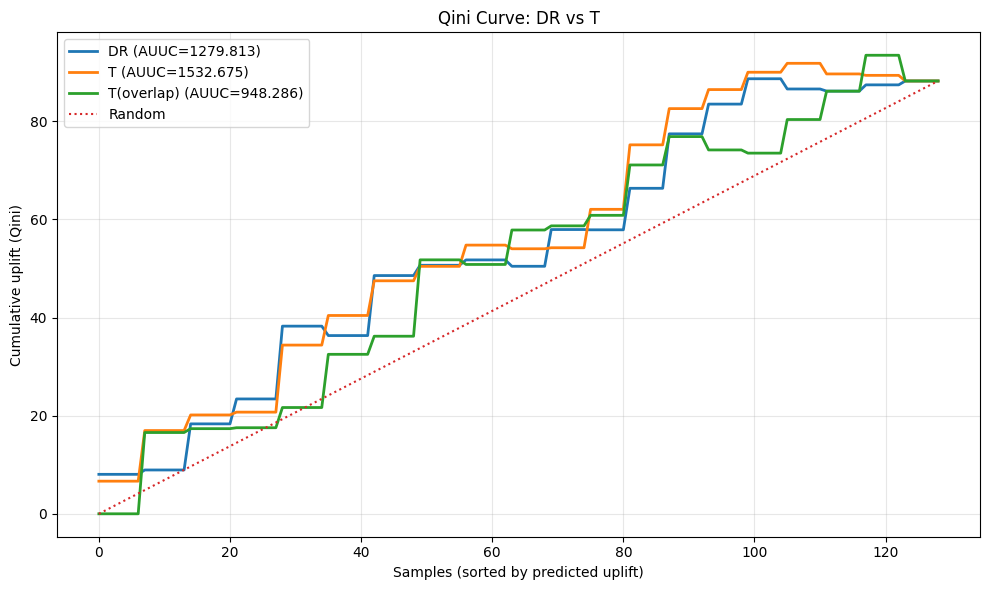


AUUC（DR, raw）: 1279.813
AUUC（DR, normalized by N_test）: 9.921031
AUUC（T, raw）: 1532.675
AUUC（T, normalized by N_test）: 11.881205
AUUC（T(overlap), raw）: 948.286
AUUC（T(overlap), normalized by N_test）: 7.351057
健全性チェックで気になる点はありませんでした。


In [15]:
# --- 健全性チェック（重み・ドロップ率など）
diag = res["diagnostics"]
print("\n=== 健全性チェック（データ/重みの安定性：trim後train） ===")
print(f"使用した trim: {diag.get('used_trim')}")
print(f"drop率（train）: {diag.get('drop_rate_train'):.3f} | （test）: {diag.get('drop_rate_test'):.3f}")
print(f"N_train={diag.get('n_train')} N_test={diag.get('n_test')}")
print(f"ESS比（treated）: {diag.get('ess_ratio_treat'):.3f} | （control）: {diag.get('ess_ratio_ctrl'):.3f}")
print(f"Weighted SMD（上位{cfg.WSMD_TOPK}平均）: {diag.get('wsmd_topk_mean'):.3f}（最大={diag.get('wsmd_top1'):.3f}）")

# --- 健全性チェック（policy作成に使用するランキングが崩れてないか）
print("\n=== 健全性チェック（ランキング指標：Qini/AUUC） ===")

print("\n--- Bin/Cum Uplift Table（DR） ---")
print(res["eval_dr"]["table"].to_string(index=False))

qini_list = [("DR", res["eval_dr"]["qini"])]
if res["eval_t"] is not None:
    print("\n--- Bin/Cum Uplift Table（T） ---")
    print(res["eval_t"]["table"].to_string(index=False))
    qini_list.append(("T", res["eval_t"]["qini"]))


if res.get("eval_t_ow") is not None:
    print("\n--- Bin/Cum Uplift Table（T: trim + overlap weights） ---")
    print(res["eval_t_ow"]["table"].to_string(index=False))
    qini_list.append(("T(overlap)", res["eval_t_ow"]["qini"]))

plot_qini("Qini Curve: DR vs T", qini_list)

auuc_dr = float(res["eval_dr"]["auuc"])
print(f"\nAUUC（DR, raw）: {auuc_dr:.3f}")
if cfg.REPORT_AUUC_NORMALIZED:
    n_test = len(res["out"])
    print(f"AUUC（DR, normalized by N_test）: {auuc_dr / max(float(n_test), 1.0):.6f}")

auuc_t = None
if res["eval_t"] is not None:
    auuc_t = float(res["eval_t"]["auuc"])
    print(f"AUUC（T, raw）: {auuc_t:.3f}")
    if cfg.REPORT_AUUC_NORMALIZED:
        n_test = len(res["out"])
        print(f"AUUC（T, normalized by N_test）: {auuc_t / max(float(n_test), 1.0):.6f}")


auuc_t_ow = None
if res.get("eval_t_ow") is not None:
    auuc_t_ow = float(res["eval_t_ow"]["auuc"])
    print(f"AUUC（T(overlap), raw）: {auuc_t_ow:.3f}")
    if cfg.REPORT_AUUC_NORMALIZED:
        n_test = len(res["out"])
        print(f"AUUC（T(overlap), normalized by N_test）: {auuc_t_ow / max(float(n_test), 1.0):.6f}")

# 健全性チェックの結果評価（気になる点があればメッセージのみ出力して処理は止めない）
notes = []
if auuc_dr <= 0:
    notes.append("AUUC(DR) が 0 以下です（少なくともこのランキング順では、ランダム介入に近い、もしくはそれ以下の性能の可能性があります）。")

if diag.get("ess_ratio_ctrl", 1.0) < 0.2 or diag.get("ess_ratio_treat", 1.0) < 0.2:
    notes.append("ESS 比が小さすぎます（重みが一部に集中し、推定が不安定な可能性）。")

if diag.get("drop_rate_train", 0.0) > 0.2:
    notes.append("trimによる除外が多いです（推定対象＝比較可能領域が狭い可能性）。")

if diag.get("wsmd_topk_mean", 0.0) > 0.2:
    notes.append("重み付け後も共変量バランスが十分に改善していない可能性があります（SMDが大きい）。")

if notes:
    print("\n【注意】健全性チェックで気になる点がありました：")
    for m in notes:
        print(" - " + m)
    print("このまま policy value（最終判断指標）の推定も実行し、結果を合わせて確認します。")
else:
  print("健全性チェックで気になる点はありませんでした。")




### Step 4/4：最終判断（Policy Value）+ Robustness

ここからは **意思決定指標（主指標）**です。  
policy（Top-Kのルール）は **DR-style score / T-score** のどちらでも作れますが、評価は **同一のAIPW評価器**で揃えて比較します。

Robustness確認とターゲティング価値の評価：
- seed を変えた再評価で、**Policy Incremental Value（Top-Kの期待改善）**の傾向が安定しているかを確認します。
- さらに同じ介入人数（Top-Kと同数）をランダムに選ぶ policy を複数回ランダムサンプリングで評価し、モデルによって選択されたTop-Kがランダムに選択された結果を上回るか（= ターゲティングの価値）を確認します

#### 注意点（Policy Value の解釈）
- **Incremental Value = Policy Value − TreatNone** です。  
  「このTop-Kルールで介入したとき、**何もしない場合に比べて**平均アウトカムがどれだけ上がるか」を表します。
- CI（信頼区間）は bootstrap（データを引き直す疑似実験）で作っています。  
  これは主に「データが有限であることによるブレ（サンプルの偶然）」を表します。  
  ※一方で、モデルの作り方（ハイパラ調整やモデル選択）やPS推定のブレまで厳密に全部は反映していません。
- この評価は **観察データ**に基づくため、結果の解釈には前提があります。  
  ざっくり言うと、(1) 介入の有無で違っていそうな要因は説明変数として十分入っている（入れ忘れが少ない）こと、  
  (2) 介入あり・なしの両方が起こりうる「比較できる範囲」で評価できていること、が重要です。  
  なお今回は **トリミング**により、**外挿しない範囲（評価スコープ）**に限定しています。
- 今回は **トリミング後のデータ**で評価しているため、結果は「全員」ではなく、**“トリミング後集団”に対する効果（ATE@trim）**として解釈します。  
  （トリミングで除外される層は一般的に極端な層になりやすく、実務ではルールベースで別途判断することがあります）



=== 最終判断指標：Policy Value（AIPW） ===

--- policy（DR-style scoreでTop-K）を AIPW で評価 ---


,TopK,N_treated,PolicyValue,Baseline(TreatNone),IncrementalValue,CI_low,CI_high
0,5%,6,2.971219,2.864997,0.106222,0.079191,0.269997
1,10%,12,3.158309,2.864997,0.293312,0.223266,0.527733
2,20%,25,3.611538,2.864997,0.746541,0.519692,0.968832
3,30%,38,4.011108,2.864997,1.146111,0.839156,1.469216
4,40%,51,4.509925,2.864997,1.644928,1.316038,2.244190



--- policy（T-scoreでTop-K）を 同一AIPW評価器で評価（T: trim only） ---


,TopK,N_treated,PolicyValue,Baseline(TreatNone),IncrementalValue,CI_low,CI_high
0,5%,6,3.269255,2.864997,0.404257,0.153707,0.652846
1,10%,12,3.488378,2.864997,0.623380,0.341567,1.214323
2,20%,25,3.903733,2.864997,1.038736,0.718446,1.571658
3,30%,38,4.374174,2.864997,1.509177,1.096653,1.853895
4,40%,51,4.570220,2.864997,1.705223,1.319397,2.228481



--- policy（T-scoreでTop-K）を 同一AIPW評価器で評価（T: trim + overlap weights） ---


,TopK,N_treated,PolicyValue,Baseline(TreatNone),IncrementalValue,CI_low,CI_high
0,5%,6,3.070900,2.864997,0.205903,0.163690,0.634002
1,10%,12,3.505740,2.864997,0.640743,0.372793,0.855637
2,20%,25,3.972324,2.864997,1.107327,0.676774,1.489789
3,30%,38,4.387592,2.864997,1.522595,0.964066,1.952949
4,40%,51,4.641682,2.864997,1.776685,1.369291,2.386204


<Figure size 800x500 with 0 Axes>

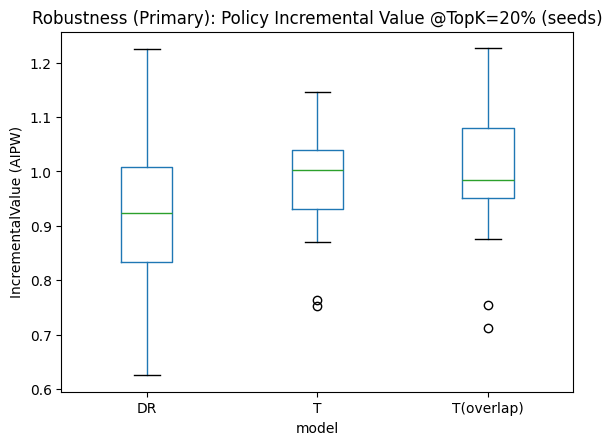


[Primary] Policy Incremental Value summary by model:
            count      mean       std       min       10%       25%       50%       75%       90%       max
model                                                                                                      
DR           30.0  0.920544  0.132295  0.624921  0.744993  0.834251  0.924401  1.008245  1.050652  1.225998
T            30.0  0.988530  0.097474  0.752176  0.888675  0.930533  1.002327  1.038648  1.108902  1.145934
T(overlap)   30.0  0.998161  0.111527  0.712049  0.893976  0.950519  0.984170  1.079342  1.113100  1.227026


<Figure size 800x500 with 0 Axes>

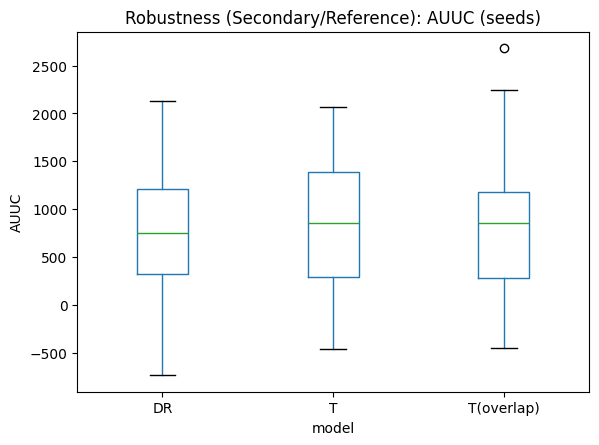

[Secondary] Paired t-test p-value (AUUC, DR vs T): 0.00218


In [16]:
# --- Final decision metric: Policy Value (AIPW) ---
print("\n=== 最終判断指標：Policy Value（AIPW） ===")

print("\n--- policy（DR-style scoreでTop-K）を AIPW で評価 ---")
display(res["policy_dr"])

if res.get("policy_t") is not None:
    print("\n--- policy（T-scoreでTop-K）を 同一AIPW評価器で評価（T: trim only） ---")
    display(res["policy_t"])

if res.get("policy_t_ow") is not None:
    print("\n--- policy（T-scoreでTop-K）を 同一AIPW評価器で評価（T: trim + overlap weights） ---")
    display(res["policy_t_ow"])

# robustnessの評価実施
if cfg.RUN_ROBUSTNESS:
    run_robustness(df, features, cfg, ps_C, lgbm_params)


In [17]:
print("\n=== DR-Learnearで作成したpolicyによるターゲッティング価値チェック：Model Top-K vs Random Top-K（AIPW） ===")
tbl = evaluate_targeting_gain_vs_random(
    df=res["out"],
    cfg=cfg,
    pred_col=cfg.COL_PRED_DR,   # ここの設定でモデルを変更しています
    topk_list=[0.05, 0.10, 0.20, 0.30, 0.40],
    random_R=200, #ランダムにtopKを選択する選択回数（モンテカルロサンプリングの実行回数）
    seed=0,
)
print(tbl.to_string(index=False))

print("\n=== T-Learnearで作成したpolicyによるターゲッティング価値チェック：Model Top-K vs Random Top-K（AIPW） ===")
tbl = evaluate_targeting_gain_vs_random(
    df=res["out"],
    cfg=cfg,
    pred_col=cfg.COL_PRED_T,
    topk_list=[0.05, 0.10, 0.20, 0.30, 0.40],
    random_R=200,
    seed=0,
)
print(tbl.to_string(index=False))

if getattr(cfg, "COL_PRED_T_OW", None) is not None and cfg.COL_PRED_T_OW in res["out"].columns:
    print("\n=== T-Learnear（trim+overlap weights）で作成したpolicyによるターゲッティング価値チェック：Model Top-K vs Random Top-K（AIPW） ===")
    tbl = evaluate_targeting_gain_vs_random(
        df=res["out"],
        cfg=cfg,
        pred_col=cfg.COL_PRED_T_OW,
        topk_list=[0.05, 0.10, 0.20, 0.30, 0.40],
        random_R=200,
        seed=0,
    )
    print(tbl.to_string(index=False))



=== DR-Learnearで作成したpolicyによるターゲッティング価値チェック：Model Top-K vs Random Top-K（AIPW） ===
TopK  N_treated  Model_Incremental  Random_Incremental_mean  Random_Incremental_p10  Random_Incremental_p90  TargetingGain(Model - RandomMean)  P(random >= model)
  5%          6           0.106222                 0.163873                0.086004                0.246464                          -0.057651               0.845
 10%         12           0.293312                 0.329328                0.211771                0.451907                          -0.036016               0.640
 20%         25           0.746541                 0.676221                0.525342                0.841045                           0.070320               0.290
 30%         38           1.146111                 1.036315                0.828110                1.271009                           0.109796               0.240
 40%         51           1.644928                 1.403965                1.158235                1.6

## まとめ（モデリング結果）

本notebookでは、観察データにおける比較不能領域（極端なPS）を避けるため **トリミング（trim=0.05）** を行い、
そのトリミング後集団を母集団とみなして **Top-K policy** を作成・評価しました。

- **主評価**：トリミング後集団に対する **Policy Value（AIPW）**（= Incremental Value）
- **参考指標**：AUUC/Qini（ランキング形状のチェック）
- **補助評価**：Model Top-K vs Random Top-K（「ランダムより良いターゲティングか」）

また、ランキング作成（学習）の安定化策として **overlap weights** を入れたT-learnerも追加し、以下の3パターンを比較しました。

- **T (trim)**：T-learner（トリミングのみ）※ベースライン
- **T (trim + overlap)**：T-learner（overlap weightsで学習を安定化）
- **DR (trim + overlap)**：DR-style（overlap weights）

---

### 1) 健全性チェック（trim後 train）
- 使用したトリミング：**0.05**
- drop率：**train 16.6% / test 14.0%**
- ESS比：**treated 0.962 / control 0.710**（重み集中が極端ではない）
- Weighted SMD（上位10平均）：**0.078**（最大 **0.167**）  

drop率（トリミングによって削除された割合）、ESS、重み付け後の共変量バランスは妥当な範囲と判断しました。

---

### 2) 参考：ランキング指標（AUUC / Qini）
- AUUC（DR, trim+overlap）：1279.8
- AUUC（T, trim）：1532.7
- AUUC（T, trim+overlap）：948.3

今回の結果では、AUUCの大小に差はあるものの、少なくとも極端に不自然な形状（序盤から一貫してマイナスが続く等）は見られず、ランキングとしての健全性チェックは概ねクリアしていると判断しています（詳細はQini曲線も参照）

---

### 3) 主評価：Policy Value（AIPW）
TreatNone（誰にも介入しない）をベースラインとし、Top-Kで介入したときの改善量（Incremental Value）を評価しました。

- **DR (trim+overlap)**：Top20%で **+0.747**（CI: **[0.520, 0.969]**）
- **T (trim)**：Top20%で **+1.039**（CI: **[0.718, 1.572]**）

（今回の実行では、TopKが大きいほど改善が単調に増える傾向が見られました）

---

### 4) Robustness（seed変更 + ランダムTop-K比較）
**(a) seed変更（TopK=20%）**
- DR：平均 **0.921**（std **0.132**）
- T（trim）：平均 **0.989**（std **0.097**）  
→ seedを変えても「Top20%でプラス」という傾向は概ね維持されました。

**(b) ターゲティング価値（Model Top-K vs Random Top-K）**
「介入した方が基本的に良い」データでは、ランダムに同数へ介入しても改善が出ます。  
そこで同じ介入人数Kで **ランダムにK人を選ぶ**ことを多数回繰り返し、モデルpolicyとの比較を行いました。

- **DR (trim+overlap)**
  - Top5% / Top10%：**ランダム平均に負ける**（TargetingGainがマイナス、P(random ≥ model)も高い）
  - Top20% 以上：**ランダム平均を上回る**（TargetingGainがプラス）  
    ただし、Top20〜30%では **P(random ≥ model) が 0.24〜0.29 程度**で、まだブレが大きい可能性があります。

- **T (trim)**
  - Top5%〜Top40%の全てで **ランダム平均を上回る**（TargetingGainがプラス）
  - **P(random ≥ model) も概ね低い（例：0.015, 0.005 など）**  
    → 少なくとも今回のデータでは、T (trim) が「ランダムより良いターゲティング」を安定して示しました。

- **T (trim + overlap)**
  - **Top10%〜Top40%で一貫してランダム平均を上回り、かつT (trim) を上回る傾向**  
    （TargetingGainが 10〜40%で最大、P(random ≥ model) も 0.01〜0.00 程度まで低下）
  - 一方で **Top5%では優位が弱い**（TargetingGainは小さく、P(random ≥ model) も高め）  
    → 「Kが小さい（Top5%）」の一点当てでは、overlap weightsにより“比較可能領域”へ寄る分、尖った上位を取り逃がしてる可能性あり

解釈として、TopKが小さい領域（例：Top5%でN_treated=6）は**サンプルが少なくブレが大きい**ため、「上位だけを狙う」ほど不確実性が増えやすいです。  
今回の結果は、**Kの大きさ（これは運用上の制約や予算で決まる）によって最適な学習設計が変わりうる**ことを示唆しています。

---

### 5) 結論（今回の意思決定として）
- 主評価（AIPW）で見る限り、**DR/TいずれのTop-K介入も TreatNone に比べて改善**しています。
- ただし「ターゲティングの価値（ランダムより上か）」まで見ると、今回のデータでは以下の差が明確でした。
  - **小さいTopK（例：Top5%）を狙う運用**：**T (trim)** が最も強い
  - **中〜大きいTopK（例：Top10〜40%）で運用**：**T (trim + overlap)** が最も安定して強い
  - **DR (trim + overlap)** は特に小さいTopKで不安定（ランダムに負ける確率が高い）

---

### 6) 実務での示唆（T / DR / overlap の使い分け）
今回の結果は「どの手法が常に最良か」ではなく、**運用制約（Top-Kの大きさ）とデータ条件（サンプルサイズ・overlap）に応じて最適が変わる**ことを示しています。

#### T (trim) が採用されやすいケース
- **Top-Kが小さい（例：上位5%〜10%）運用が主目的**  
  少人数ターゲティングでは「並べ替えの質」が支配的になりやすく、実証的に強いスコアを優先しやすい。
- **トリミング後の共通サポートが十分で、外挿リスクが相対的に小さい**
- **説明可能性・保守性を優先したい**（構造が単純で運用・監視がしやすい）

#### T (trim + overlap) が採用されやすいケース
- **Top-Kが中〜大（例：10%〜40%）で、安定した順位付けが重要**  
  overlap weights により比較可能領域を重視し、ランキング中盤を含めた安定化が効きやすい。
- **外挿になりやすい領域の影響を抑えて、平均的に勝つ設計にしたい**

#### DR が採用されやすい（なりやすい）ケース
- **データや運用が変わりやすい（ドリフトが大きい）**  
  PSやアウトカム生成過程が動きやすい場合、両方の補助的なモデル（μとPS）を使う設計が有利になることがある。
- **PSの偏りが強く、交絡が重そうで不安**（※未観測交絡を解決するわけではない）
- **十分なデータ量があり、cross-fitting等で分散を抑えられる**  
  小標本・小TopKでは分散が支配しやすく、今回のように不利になることがある。

---

### 7) 実務的な意思決定の落とし所
- まずは **Policy Value（AIPW）** と **Model Top-K vs Random Top-K** で候補を絞る（「ランダムより良いか」を重視）
- 運用上のK（予算）に合わせて、**小KならT(trim)、中〜大KならT(trim+overlap)** のように選択肢を持つ
- 差が僅差ならモデルを並走し、運用データで再評価できる設計にする
- 最終的にはオンライン（ABテスト推奨）で「Top-K vs ランダムK（または現行ルール）」を検証する

---

### 8) プロダクト組み込みとオンライン評価（簡単に記載しています）
本notebookは観察データから **Top-K policy を設計・オフライン評価**するフェーズであり、最終的にはオンラインで検証します。

- **組み込みイメージ**
  - 定期バッチ（例：日次/週次）でスコアを算出し、上位K%を「介入対象リスト」として出力
  - 介入システム（配信/営業/サポート等）は、そのリストに基づき介入を実行
- **オンライン評価（推奨）**
  - 可能なら **ABテスト**で「Top-Kに介入」vs「ランダムKに介入」または「現行ルール」の比較を行い、
    オフラインで見えた **ターゲティング価値（ランダムより上回るか）** が再現するか確認する
  - Kが小さいほどブレが大きくなりやすいため、Kは施策制約に加えて想定サンプルサイズも見ながら決定する
  - 併せて、介入率・対象属性の偏り・主要KPIのドリフト監視を行い、定期的に再学習/再評価する

#### 補足：介入対象の偏りを防ぐための「探索枠」の設定（運用上はとても重要な観点です）
同じupliftスコアで毎回Top-K介入だけを行うと、介入対象が特定の属性に偏りやすく、
学習データの多様性が失われたり、偏りが強化されるリスクがあります。

実務ではこの偏りを避けるため、介入枠の一部を「探索枠」としてランダム（必要なら分層ランダム）に割り当て、
データの多様性とオンライン検証のしやすさを確保します（例：介入枠の20%のうち、16%はTop-K、4%はランダム）。


# Appendix1：T-Learner / DR-style の数学的な解釈

### 記法の説明
- 介入：$T \in \{0,1\}$
- 共変量：$X$
- 観測アウトカム：$Y$
- 傾向スコア：$e(x)=P(T=1 \mid X=x)$

---

### T-Learner（介入あり/なしの予測差）
介入群・対照群それぞれでアウトカムモデルを学習する：

$$
\hat{\mu}_1(x)\approx \mathbb{E}[Y\mid T=1,X=x],\quad
\hat{\mu}_0(x)\approx \mathbb{E}[Y\mid T=0,X=x]
$$

uplift スコアは予測差：

$$
s_T(x)=\hat{\mu}_1(x)-\hat{\mu}_0(x)
$$

---

### DR-style（residual correction + overlap重視）
DR-style は「予測差」に加えて、**残差（観測 $Y$ と予測のズレ）**を使って補正した擬似アウトカムを作り、uplift を学習します。

本Notebookの DR-style は、学習の安定化目的で **overlap を相対的に重視**した重みを使います：

$$
w_1(x)=1-e(x),\quad w_0(x)=e(x)
$$

擬似アウトカムを作り、

$$
\tilde{\tau}(x) = (\hat{\mu}_1(x) - \hat{\mu}_0(x)) + T \cdot w_1(x) \cdot (Y-\hat{\mu}_1(x)) - (1-T) \cdot w_0(x) \cdot (Y-\hat{\mu}_0(x))
$$

最後に

$$
\hat{\tau}_{\text{DR-style}}(x) \approx \mathbb{E}[\tilde{\tau}\mid X=x]
$$

を学習し、ランキング（Top-K policy作成）に用います。

注意：標準的な DR（ATE を狙う二重頑健性）では、通常 $1/e(x)$ や $1/(1-e(x))$ のようなIPW由来の項が現れます。  
ここでは「厳密な二重頑健性」を主張するのではなく、**比較可能領域を重視してランキングを安定化**することを優先し、overlap重みを用いた DR-style として扱っています。

---

### 直感（超要約）
- **T**：$\hat{\mu}_1-\hat{\mu}_0$ をそのまま uplift として使う
- **DR-style**：予測差に「残差補正」を足した擬似ラベルを作り、ランキングを安定化しやすくする（※主評価は AIPW の Policy Value）

# APPENDIX2: AIPW推定量の数式

## 記法

**観測データ**
- $T_i$：処置（0 or 1）
- $Y_i$：観測されたアウトカム
- $X_i$：共変量（特徴量）

**傾向スコア（Propensity Score）**

$$e(x) = P(T=1 \mid X=x)$$

共変量 $X=x$ が与えられたときに、処置を受ける確率。
観察データでは介入がランダムではないため、「どういう人が介入されやすかったか」をモデル化したもの。

**アウトカムモデル**

$$\mu_1(x) = E[Y \mid T=1, X=x]$$

$$\mu_0(x) = E[Y \mid T=0, X=x]$$

- $\mu_1(x)$：介入を受けた場合の期待アウトカム
- $\mu_0(x)$：介入を受けなかった場合の期待アウトカム

**処置効果**

$$\tau(x) = \mu_1(x) - \mu_0(x) = E[Y(1) - Y(0) \mid X=x]$$

共変量 $X=x$ で条件付けた平均処置効果（CATE: Conditional Average Treatment Effect）。
同じXを持つ人たちのグループ内での平均的な効果を表す。

※ 個人レベルの効果（ITE: Individual Treatment Effect）は $\tau_i = Y_i(1) - Y_i(0)$ だが、
同一個人に両方の処置を施せないため直接観測できない

---

## 各推定量の比較

### 単純比較（バイアスあり）

$$\hat{\tau}_{naive} = \bar{Y}_{T=1} - \bar{Y}_{T=0}$$

---

### 回帰推定（G-computation）

$$\hat{\tau}_{reg} = \frac{1}{n}\sum_{i=1}^{n}\left[\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)\right]$$

- 一致性の条件： $\mu_1, \mu_0$ が正しい
- 弱点：アウトカムモデルが間違っているとバイアス

---

### IPW（逆確率重み付け）

$$\hat{\tau}_{IPW} = \frac{1}{n}\sum_{i=1}^{n}\left[\frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)}\right]$$

- 一致性の条件： $e(x)$ が正しい
- 弱点： $e(x)$ が極端だと分散爆発

---

### AIPW（二重頑健推定量）

$$\hat{\tau}_{AIPW} = \frac{1}{n}\sum_{i=1}^{n}\left[\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i) + \frac{T_i (Y_i - \hat{\mu}_1(X_i))}{e(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)}\right]$$

分解すると：

回帰推定 (A)：

$$A = \frac{1}{n}\sum_{i}\left[\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)\right]$$

残差のIPW補正 (B)：

$$B = \frac{1}{n}\sum_{i}\left[\frac{T_i (Y_i - \hat{\mu}_1(X_i))}{e(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)}\right]$$

合わせて：

$$\hat{\tau}_{AIPW} = A + B$$

性質：
- 一致性の条件： $\mu$ または $e$ のどちらかが正しい（二重頑健）
- 弱点：両方間違うとバイアス（ただし積のオーダー）

---

## 個人スコアの構造

$$\tilde{\tau}_i = \left[\hat{\mu}_1(X_i) - \hat{\mu}_0(X_i)\right] + \frac{T_i (Y_i - \hat{\mu}_1(X_i))}{e(X_i)} - \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)}$$

各項の意味：
- 第1項：予測差（全員に対して計算）
- 第2項：T=1のときのみ動く補正項
- 第3項：T=0のときのみ動く補正項

**注意**：補正項は「実際に受けた処置の側」だけ動く

---

## Policy Value（AIPW）

評価したいのは「Top-K%に介入したら、介入しない場合と比べてどれだけ効果があるか」。

これを**Incremental Value**として計算する：

$$\text{Incremental Value} = V(\text{Top-K policy}) - V(\text{Treat None})$$

ここで：
- $V(\text{Top-K policy})$：上位K%に介入、それ以外は介入しない場合の期待アウトカム
- $V(\text{Treat None})$：誰にも介入しない場合の期待アウトカム

各Policy Valueは以下のAIPW推定を使う：

$$\hat{E}[Y(1)] = \frac{1}{n}\sum_{i}\left[\hat{\mu}_1(X_i) + \frac{T_i(Y_i - \hat{\mu}_1(X_i))}{e(X_i)}\right]$$

$$\hat{E}[Y(0)] = \frac{1}{n}\sum_{i}\left[\hat{\mu}_0(X_i) + \frac{(1-T_i)(Y_i - \hat{\mu}_0(X_i))}{1-e(X_i)}\right]$$


Incremental Valueは「Top-K%の人の推定処置効果の合計」に対応する。

**難しく書いてるけど要するに？**  
ここではTop-Kに選ばれた人集合に対して、「全員に介入した場合」と「誰にも介入しなかった場合」の期待アウトカムの差分（AIPWで推定）を計算し、そのTop-K内での平均をとっているだけ

---

## 重み付けの比較

### IPW weights（ATE推定用）

処置群（T=1）の場合：

$$w_i^{IPW} = \frac{1}{e(X_i)}$$

対照群（T=0）の場合：

$$w_i^{IPW} = \frac{1}{1-e(X_i)}$$

### Overlap weights（ATO推定用）

処置群（T=1）の場合：

$$w_i^{OW} = 1 - e(X_i)$$

対照群（T=0）の場合：

$$w_i^{OW} = e(X_i)$$

---

## 推定対象（Estimand）の違い

| 推定対象 | 対象集団 | 問い |
|:--|:--|:--|
| ATE | 母集団全員 | 全員に介入したら平均どれだけ効くか |
| ATT | 介入された人 | 介入された人に効いたか |
| ATC | 介入されなかった人 | 未介入者に介入したら効くか |
| ATO | 比較可能な層 | 迷う層に介入したら効くか |